# TP INTEGRADOR Series Temporales - Redes Neuronales

Esta notebook contiene la segunda parte del trabajo práctico integrador en donde se trata el tema de las redes neuronales LSTM. Contiene los siguientes puntos:

* Se eligen los datos del dataset (ídem notebook SARIMA).
* Se realiza el preprocesamiento: descuento de tendencia determinística a 168 hs.
* Se realiza el fit (ajuste) y el predict (predicción) con red neuronal GRU y LSTM.
* Se comparan los resultados de las dos redes neuronales con SARIMA y se extraen conclusiones.

By Anahi Bazet

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_predict
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.special import inv_boxcox

#Para redes neuronales
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, GRU, Dense, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Exploración de los datos y elección de la serie

Se utilizará el siguiente dataset: https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset

In [2]:
#Leer el dataset.
dataset=pd.read_csv("traffic.csv")

In [3]:
#Verificar lectura.
dataset.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [4]:
#Obtener cantidad de muestras y tipos de datos.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [5]:
#Cambiar el tipo de dato de la fecha/hora de objeto a datetime.
pd.set_option('mode.chained_assignment',None)
#NOTA: esto es para evitar un warning de Pandas: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
dataset["DateTime"]=pd.to_datetime(dataset["DateTime"], format='%Y-%m-%d %H:%M:%S')

In [6]:
#Chequear el cambio.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [7]:
# Contar cuantas muestras hay por intersección.
result_count_Junction=dataset.groupby(['Junction']).Junction.count()
result_count_Junction

Junction
1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

In [8]:
#Elegir una unión y seleccionar las columnas útiles (DateTime y Vehicles)
dataset_Junction1=dataset[dataset['Junction']==1]
dataset_Junction1=dataset_Junction1.drop(columns=['Junction','ID'])

In [9]:
#Ordenar las muestras por fecha/hora en orden ascendente.
dataset_Junction1=dataset_Junction1.sort_values(["DateTime"],ascending=True)

In [10]:
#Lectura del dataset depurado.
dataset_Junction1.head(10)

,DateTime,Vehicles
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9
5,2015-11-01 05:00:00,6
6,2015-11-01 06:00:00,9
7,2015-11-01 07:00:00,8
8,2015-11-01 08:00:00,11
9,2015-11-01 09:00:00,12


### Observaciones

Se descarta la intersección 4, porque es la de menor cantidad de muestras. No hay una razón específica por la cual se elija la intersección 1; ya que la dicha, la 2 y 3 tienen la misma cantidad de datos.

## Restar la tendencia determinística del período de 168 hs.

Para el caso de las redes neuronales solo se descuenta la tendencia determinística del período de 168 hs.

El objetivo es quedarse solamente con el período de 24 hs. para simplificar el modelo de la red neuronal.

In [11]:
#Se establece como índice la columna DateTime.
dataset_Junction1 = dataset_Junction1.set_index('DateTime')
dataset_Junction1.head(10)

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
2015-11-01 05:00:00,6
2015-11-01 06:00:00,9
2015-11-01 07:00:00,8
2015-11-01 08:00:00,11


In [12]:
#Determino un período de 168 hs.
period_168=168
#Cálculo de los parámetros de la observación por cuadrados mínimos.
data_graphic_real_168=np.array(dataset_Junction1['Vehicles'])
rows_168=int(len(dataset_Junction1['Vehicles'])/period_168)
data_array=np.array(dataset_Junction1['Vehicles'])
#Se descartan los primeros datos, porque no completan un período.
cant_data=rows_168*period_168
start=len(dataset_Junction1)-cant_data
data_168=data_array[start:].reshape(rows_168,period_168)
print ("Cantidad de períodos:",data_168.shape[0])
betas_168=data_168.mean(axis=0)
print ("Parámetros estimados (betas):\n",betas_168)

Cantidad de períodos: 86
Parámetros estimados (betas):
 [44.27906977 38.08139535 32.3255814  27.54651163 23.6744186  21.06976744
 21.36046512 23.3255814  26.06976744 30.08139535 36.70930233 38.43023256
 37.89534884 35.06976744 34.53488372 34.24418605 34.10465116 34.51162791
 37.73255814 42.         43.30232558 41.27906977 41.39534884 39.6627907
 35.98837209 30.15116279 25.54651163 22.95348837 20.37209302 18.97674419
 19.73255814 21.6627907  24.45348837 29.46511628 33.47674419 35.3372093
 36.02325581 34.22093023 33.5        33.59302326 33.55813953 35.02325581
 39.86046512 44.1744186  44.02325581 42.90697674 43.23255814 42.13953488
 38.41860465 32.6627907  28.26744186 26.13953488 23.72093023 23.47674419
 26.58139535 31.03488372 34.68604651 42.58139535 56.70930233 67.84883721
 68.54651163 60.25581395 65.91860465 65.30232558 61.80232558 61.80232558
 64.91860465 68.45348837 65.94186047 62.05813953 59.84883721 56.1627907
 50.86046512 44.         38.75581395 33.         28.73255814 26.7441860

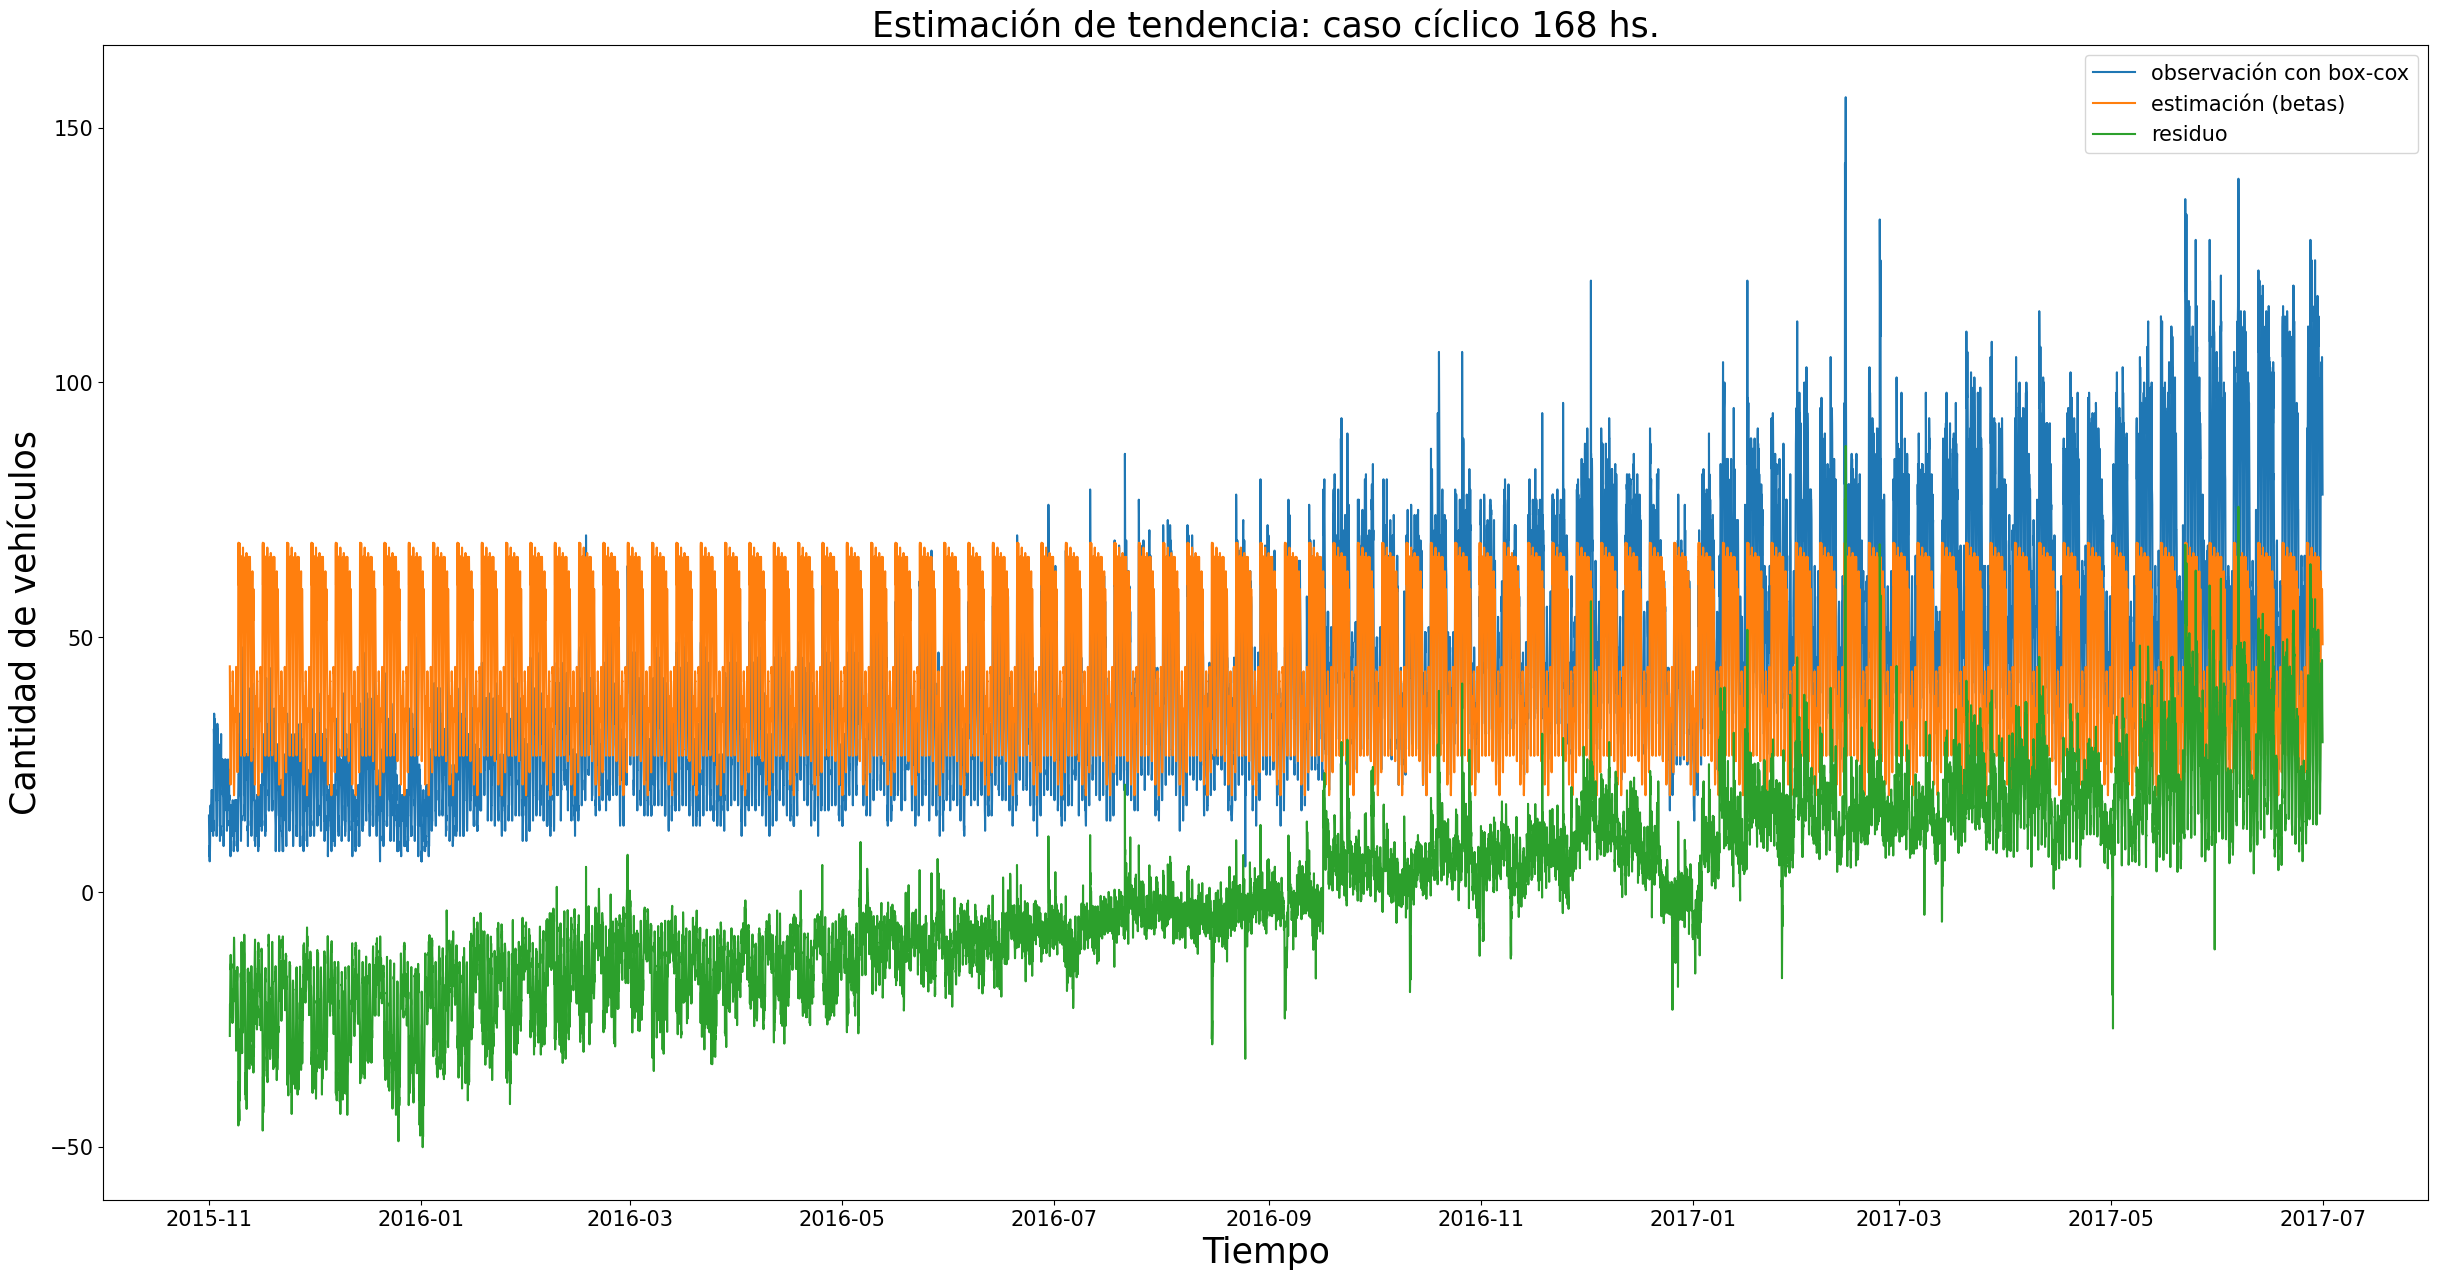

In [13]:
parameters = {'axes.labelsize': 25,
              'axes.titlesize': 25,
              'figure.figsize': (30,15),
              'xtick.labelsize': 15,
              'ytick.labelsize': 15,
              'legend.fontsize': 15}
plt.rcParams.update(parameters)
#Se muestra a lo largo de toda la serie.
est_168=np.tile(betas_168,rows_168)
# Plotea todas las observaciones (valor real).
plt.plot(dataset_Junction1.index,data_graphic_real_168,label='observación con box-cox')
# Plotea las estimaciones de las observaciones.
plt.plot(dataset_Junction1[start:].index,est_168,label='estimación (betas)')
# Plotea la diferencia entre el valor real y el estimado.
# Para el valor real solo se tienen en cuenta las observaciones, que tienen
# su correspondiente estimación. Es decir, se descartan las primeras, porque
# no llegan a completar un período de 168 horas.
resid=data_graphic_real_168[start:]-est_168
plt.plot(dataset_Junction1[start:].index,resid,label='residuo')
plt.title("Estimación de tendencia: caso cíclico 168 hs.")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos")
plt.show()

## Redes Neuronales

### Normalizar los datos

In [14]:
# Establecer random seed para que sea reproducible.
random.set_seed(7)

In [15]:
# Normalizar los datos.
# El reshape es porque el scaler requiere esa forma.
# print (resid.shape)
resid = resid.reshape(-1,1)
# print (resid.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
resid = scaler.fit_transform(resid)
# El flatten es para volver los datos a la forma original.
resid = resid.flatten()
# print (resid.shape)

### Separar x e y y dar forma a los datos de entrada (ventana deslizante)

In [16]:
#Función para obtener el target de cada grupo de elementos.
def get_feature_target(data,cant_element):
    end_len = len(data)
    X = []
    y = []
    steps = cant_element
    for i in range(steps, end_len):
        X.append(data[i - steps:i])
        y.append(data[i])
    X, y = np.array(X), np.array(y)
    X = np.expand_dims(X, axis=2)
    return X ,y

In [17]:
#Separar el X (grupo de elementos) del y (target).
# cant_element es la cantidad de elementos que mira hacia atrás. En este caso 24 porque el período es 24 horas.
cant_element=24
X, y = get_feature_target(resid,cant_element)
# Para calcular los grupos de elementos, X e y tienen cant_element elementos menos que la serie.
# Notar que X se va corriendo de a una posición. 
# Ej: Supongamos data:[0,1,2,3,4] y cant_element=3, tenemos que X=[0,1,2]->y=[3], X=[1,2,3]->X=[4].
# Entonces tenemos 2 grupos = cant_serie (5) - cant_element (3).
print (len(resid))
# print ("X:",X[0:4,:,:])
print (X.shape)
# print ("y:",y[0:4])
print (y.shape)

14448
(14424, 24, 1)
(14424,)


### Separar los datos en train y test

In [18]:
# Se hace el split en train y test con shuffle=false para que sea secuencial.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=False)

In [19]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(13702, 24, 1)
(13702,)
(722, 24, 1)
(722,)


In [20]:
input_shape = X_train[0].shape
print (input_shape)

(24, 1)


### Modelos

#### GRU

In [23]:
model = Sequential()
model.add(GRU(units=150, return_sequences=True, input_shape=(input_shape), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=150, return_sequences=True, input_shape=(input_shape), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True, input_shape=(input_shape), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True, input_shape=(input_shape), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=50, input_shape=(input_shape), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 150)           68850     
                                                                 
 dropout (Dropout)           (None, 24, 150)           0         
                                                                 
 gru_1 (GRU)                 (None, 24, 150)           135900    
                                                                 
 dropout_1 (Dropout)         (None, 24, 150)           0         
                                                                 
 gru_2 (GRU)                 (None, 24, 50)            30300     
                                                                 
 dropout_2 (Dropout)         (None, 24, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 24, 50)            1

##### Entrenamiento y validación

In [24]:
hist = model.fit(X_train,y_train, epochs=100, validation_split=0.2, batch_size=150)

Epoch 1/100
74/74 [==============================] - 24s 198ms/step - loss: 0.0176 - val_loss: 0.0335
Epoch 2/100
74/74 [==============================] - 12s 167ms/step - loss: 0.0080 - val_loss: 0.0236
Epoch 3/100
74/74 [==============================] - 12s 168ms/step - loss: 0.0058 - val_loss: 0.0138
Epoch 4/100
74/74 [==============================] - 12s 167ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 5/100
74/74 [==============================] - 12s 165ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 6/100
74/74 [==============================] - 12s 169ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 7/100
74/74 [==============================] - 13s 169ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 8/100
74/74 [==============================] - 13s 173ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 9/100
74/74 [==============================] - 13s 178ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 10/100
74/74 [==============================] - 20s 272ms/step - loss: 0.002

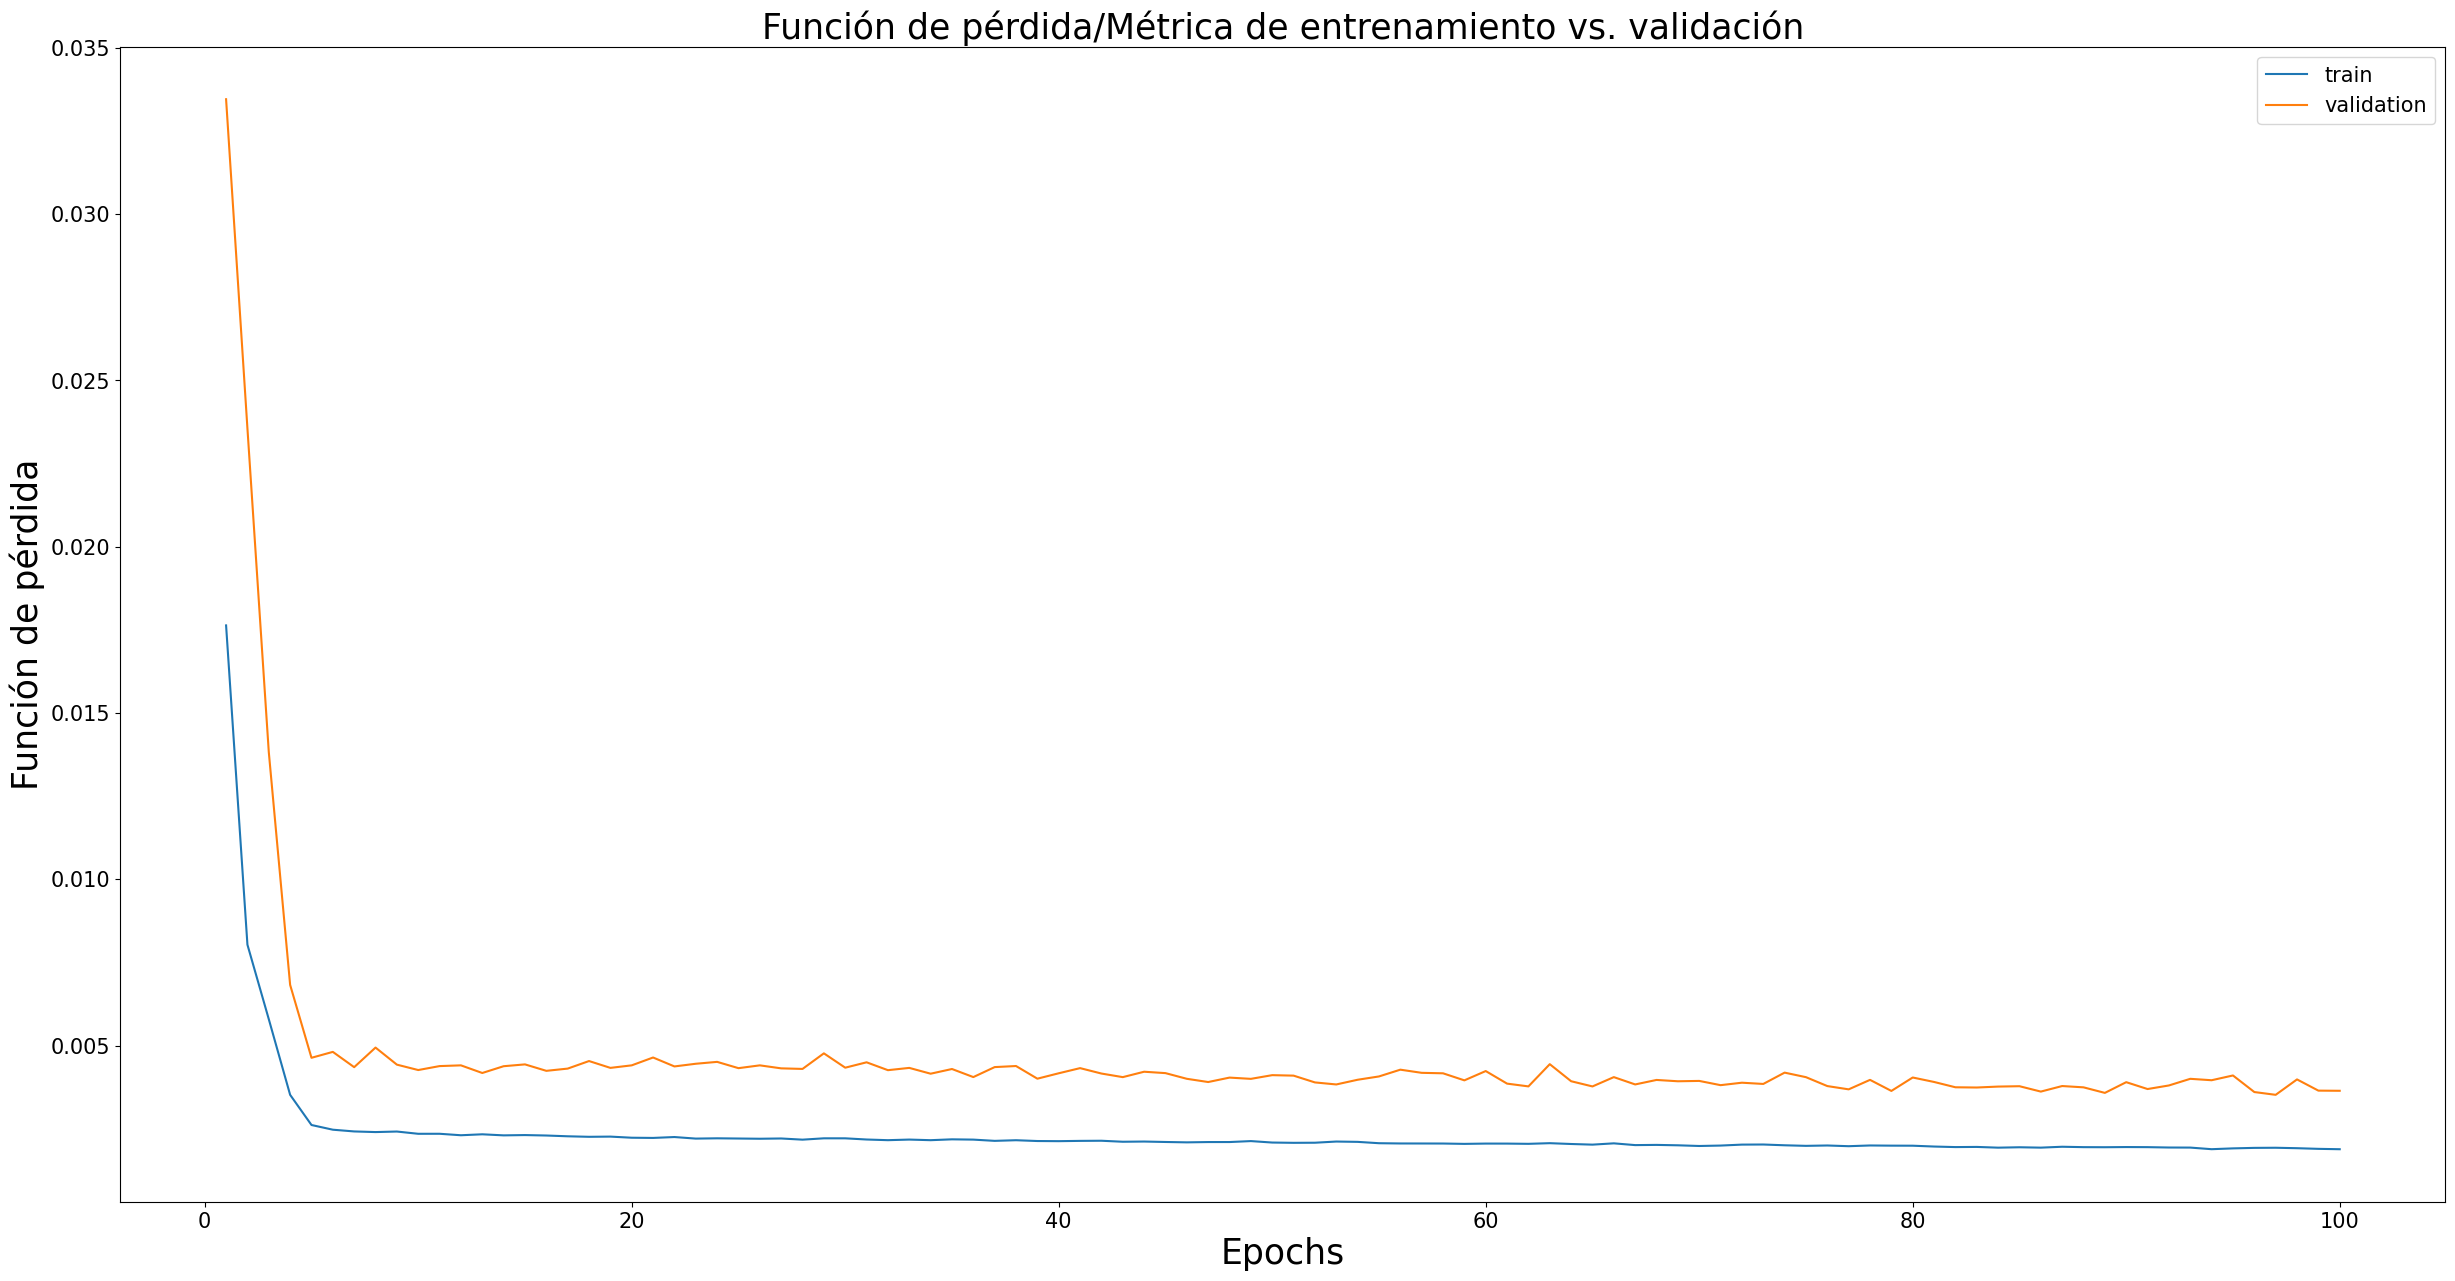

In [25]:
epoch_count = range(1, len(hist.history['loss']) + 1)
plt.plot(epoch_count,hist.history['loss'],label='train')
plt.plot(epoch_count,hist.history['val_loss'],label='validation')
plt.title("Estimación de tendencia: caso cíclico 168 hs.")
plt.legend()
plt.title ("Función de pérdida/Métrica de entrenamiento vs. validación")
plt.xlabel("Epochs")
plt.ylabel("Función de pérdida")
plt.show()

##### Test

In [26]:
mse_evaluate=model.evaluate(X_test, y_test)
print (mse_evaluate)

23/23 [==============================] - 1s 54ms/step - loss: 0.0076
0.007594444788992405


In [27]:
# Predecir solo con los datos.
# Predecir train.
y_hat_train=model.predict(X_train)
print (y_hat_train.shape)
# Predecir test.
y_hat= model.predict(X_test)
print (y_hat.shape)

(13702, 1)
(722, 1)


In [28]:
testScore = np.sqrt(mean_squared_error(y_test, y_hat.flatten()))
print('Métrica de prueba: %.2f RMSE' % (testScore))

Métrica de prueba: 0.09 RMSE


In [29]:
# Invertir las predicciones de test.
print (y_hat.shape)
y_hat = scaler.inverse_transform(y_hat)
print (y_hat.shape)
# Invertir los labels de test.
print (y_test.shape)
# El reshape es porque el scaler requiere esa forma.
y_test_inv = y_test.reshape(-1,1)
y_test_inv = scaler.inverse_transform(y_test_inv)
# El flatten es para volver los datos a la forma original.
y_test_inv = y_test_inv.flatten()
print (y_test_inv.shape)

(722, 1)
(722, 1)
(722,)
(722,)


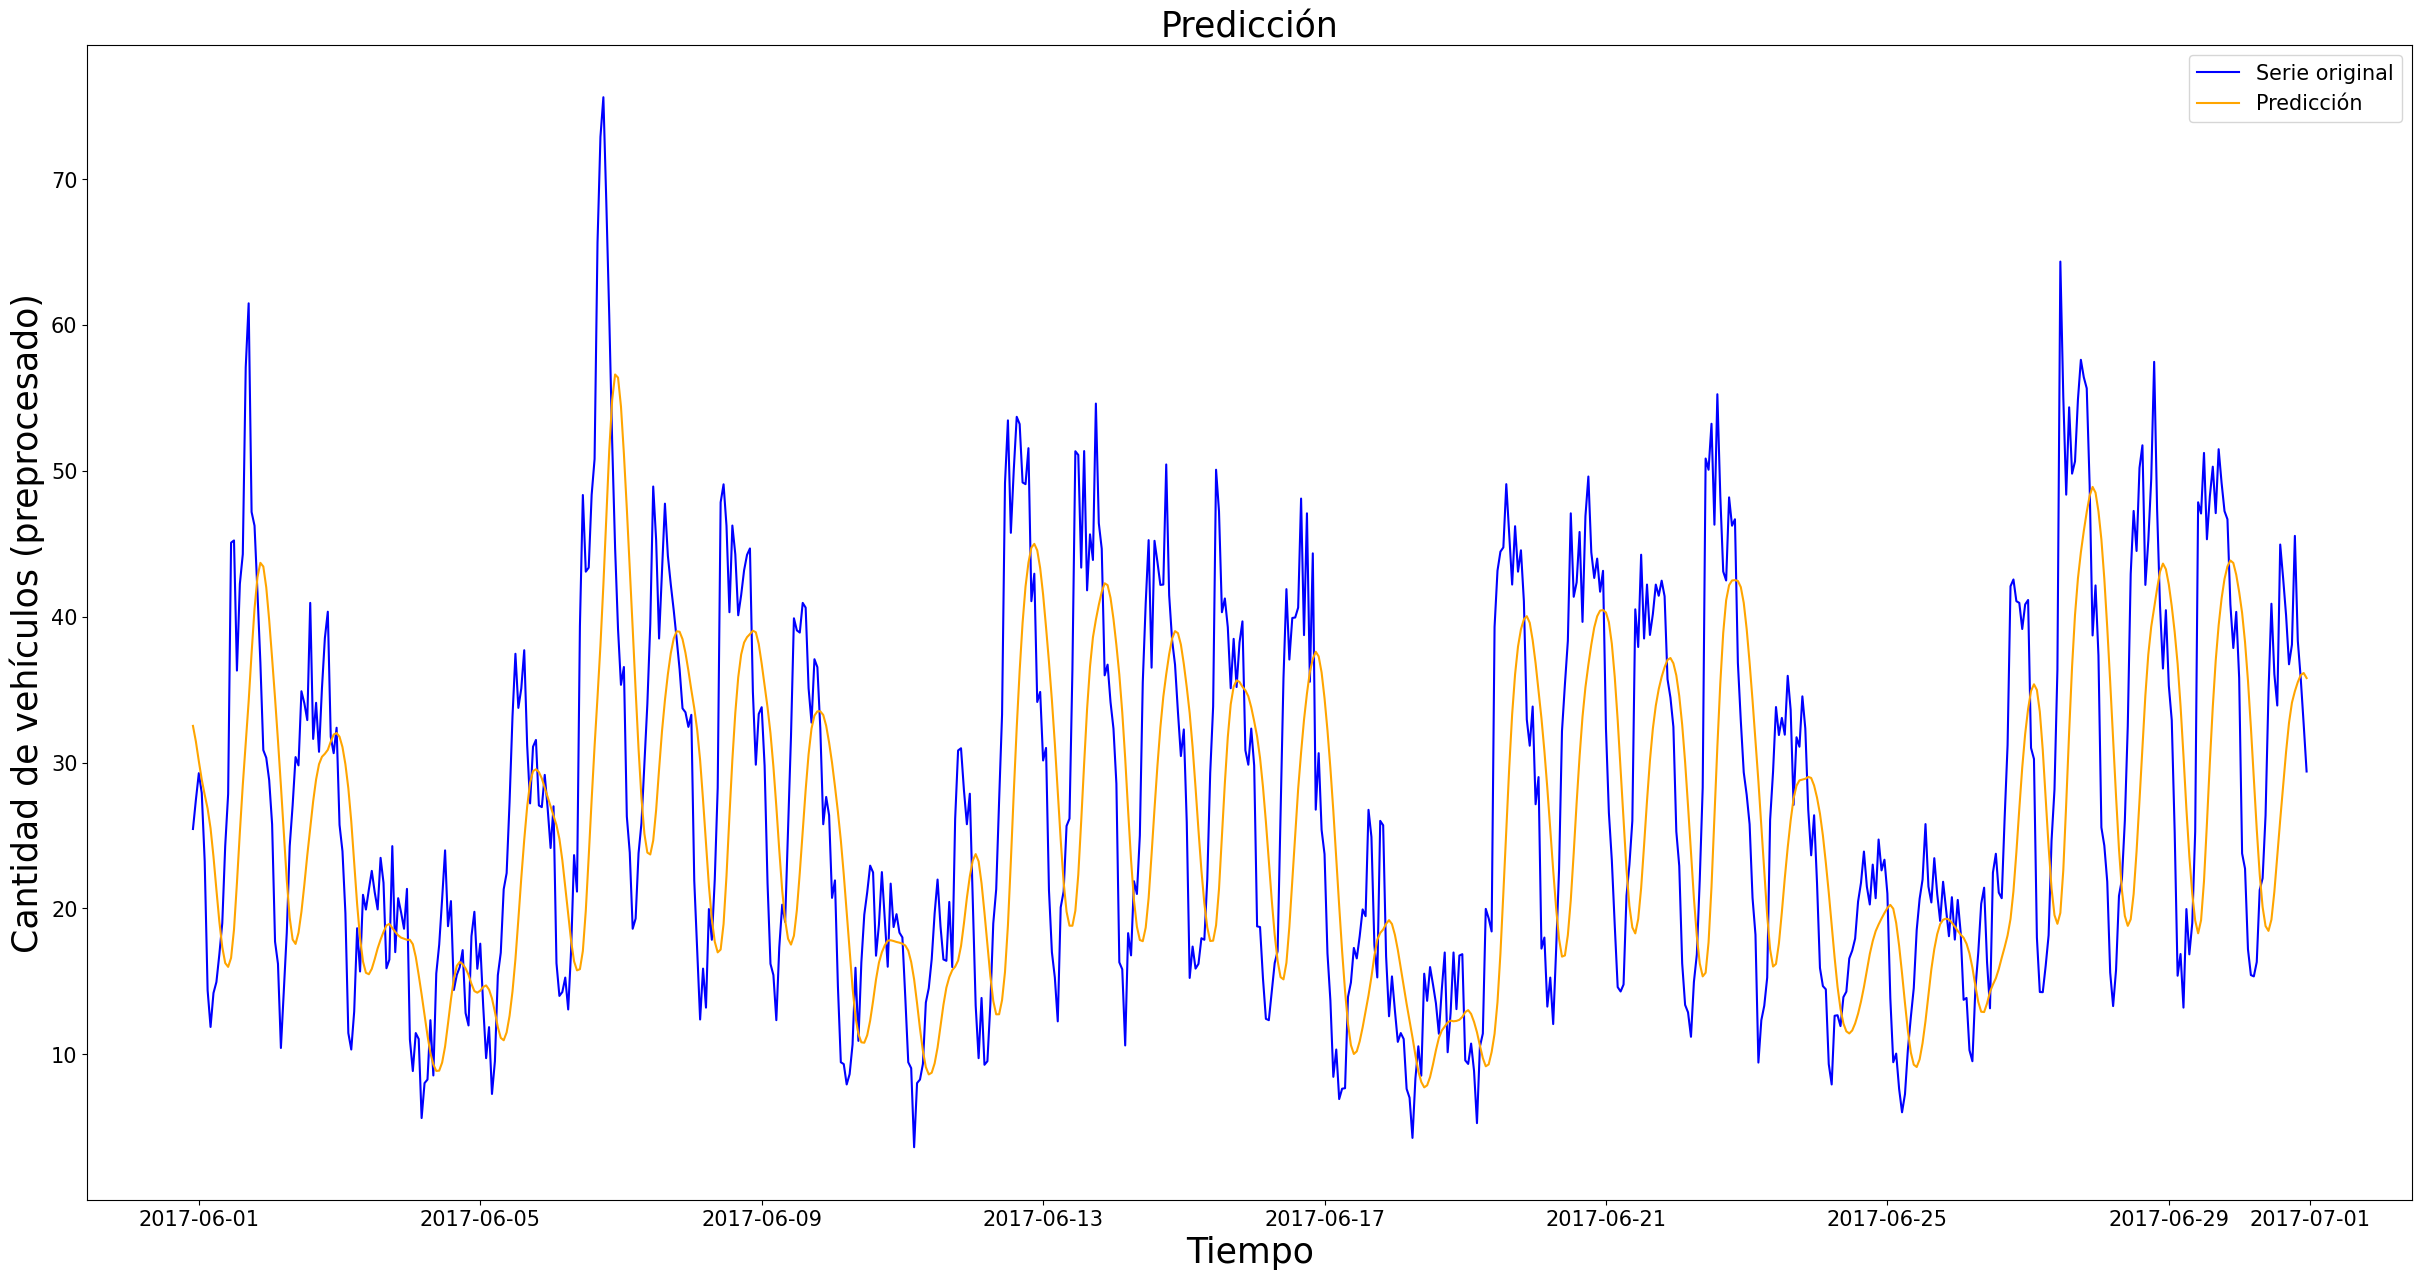

In [30]:
# Graficar datos de prueba y predicción.
init=len(resid)-len(y_test_inv)+start
plt.plot(dataset_Junction1.index[init:],y_test_inv, color="blue",label="Serie original")
plt.plot(dataset_Junction1.index[init:],y_hat, color="orange",label="Predicción")
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

In [31]:
# Invertir las predicciones de train.
print(y_hat_train.shape)
y_hat_train = scaler.inverse_transform(y_hat_train)
print (y_hat_train.shape)
# print (y_train.shape)
# # El reshape es porque el scaler requiere esa forma.
# y_train_inv = y_train.reshape(-1,1)
# y_train_inv = scaler.inverse_transform(y_train_inv)
# # El flatten es para volver los datos a la forma original.
# y_train_inv = y_train_inv.flatten()
# print (y_train_inv.shape)

(13702, 1)
(13702, 1)


In [32]:
# Mover las predicciones de train para graficar.
y_hat_train_Plot = np.empty_like(resid.reshape(-1,1))
y_hat_train_Plot[:,:] = np.nan
y_hat_train_Plot[cant_element:len(y_hat_train)+cant_element, :] = y_hat_train
print (y_hat_train_Plot.shape)

(14448, 1)


In [33]:
# Mover las predicciones de test para graficar.
y_hat_Plot = np.empty_like(resid.reshape(-1,1))
y_hat_Plot[:, :] = np.nan
y_hat_Plot[len(y_hat_train)+(cant_element):len(resid.reshape(-1,1)), :] = y_hat
print (y_hat_Plot.shape)

(14448, 1)


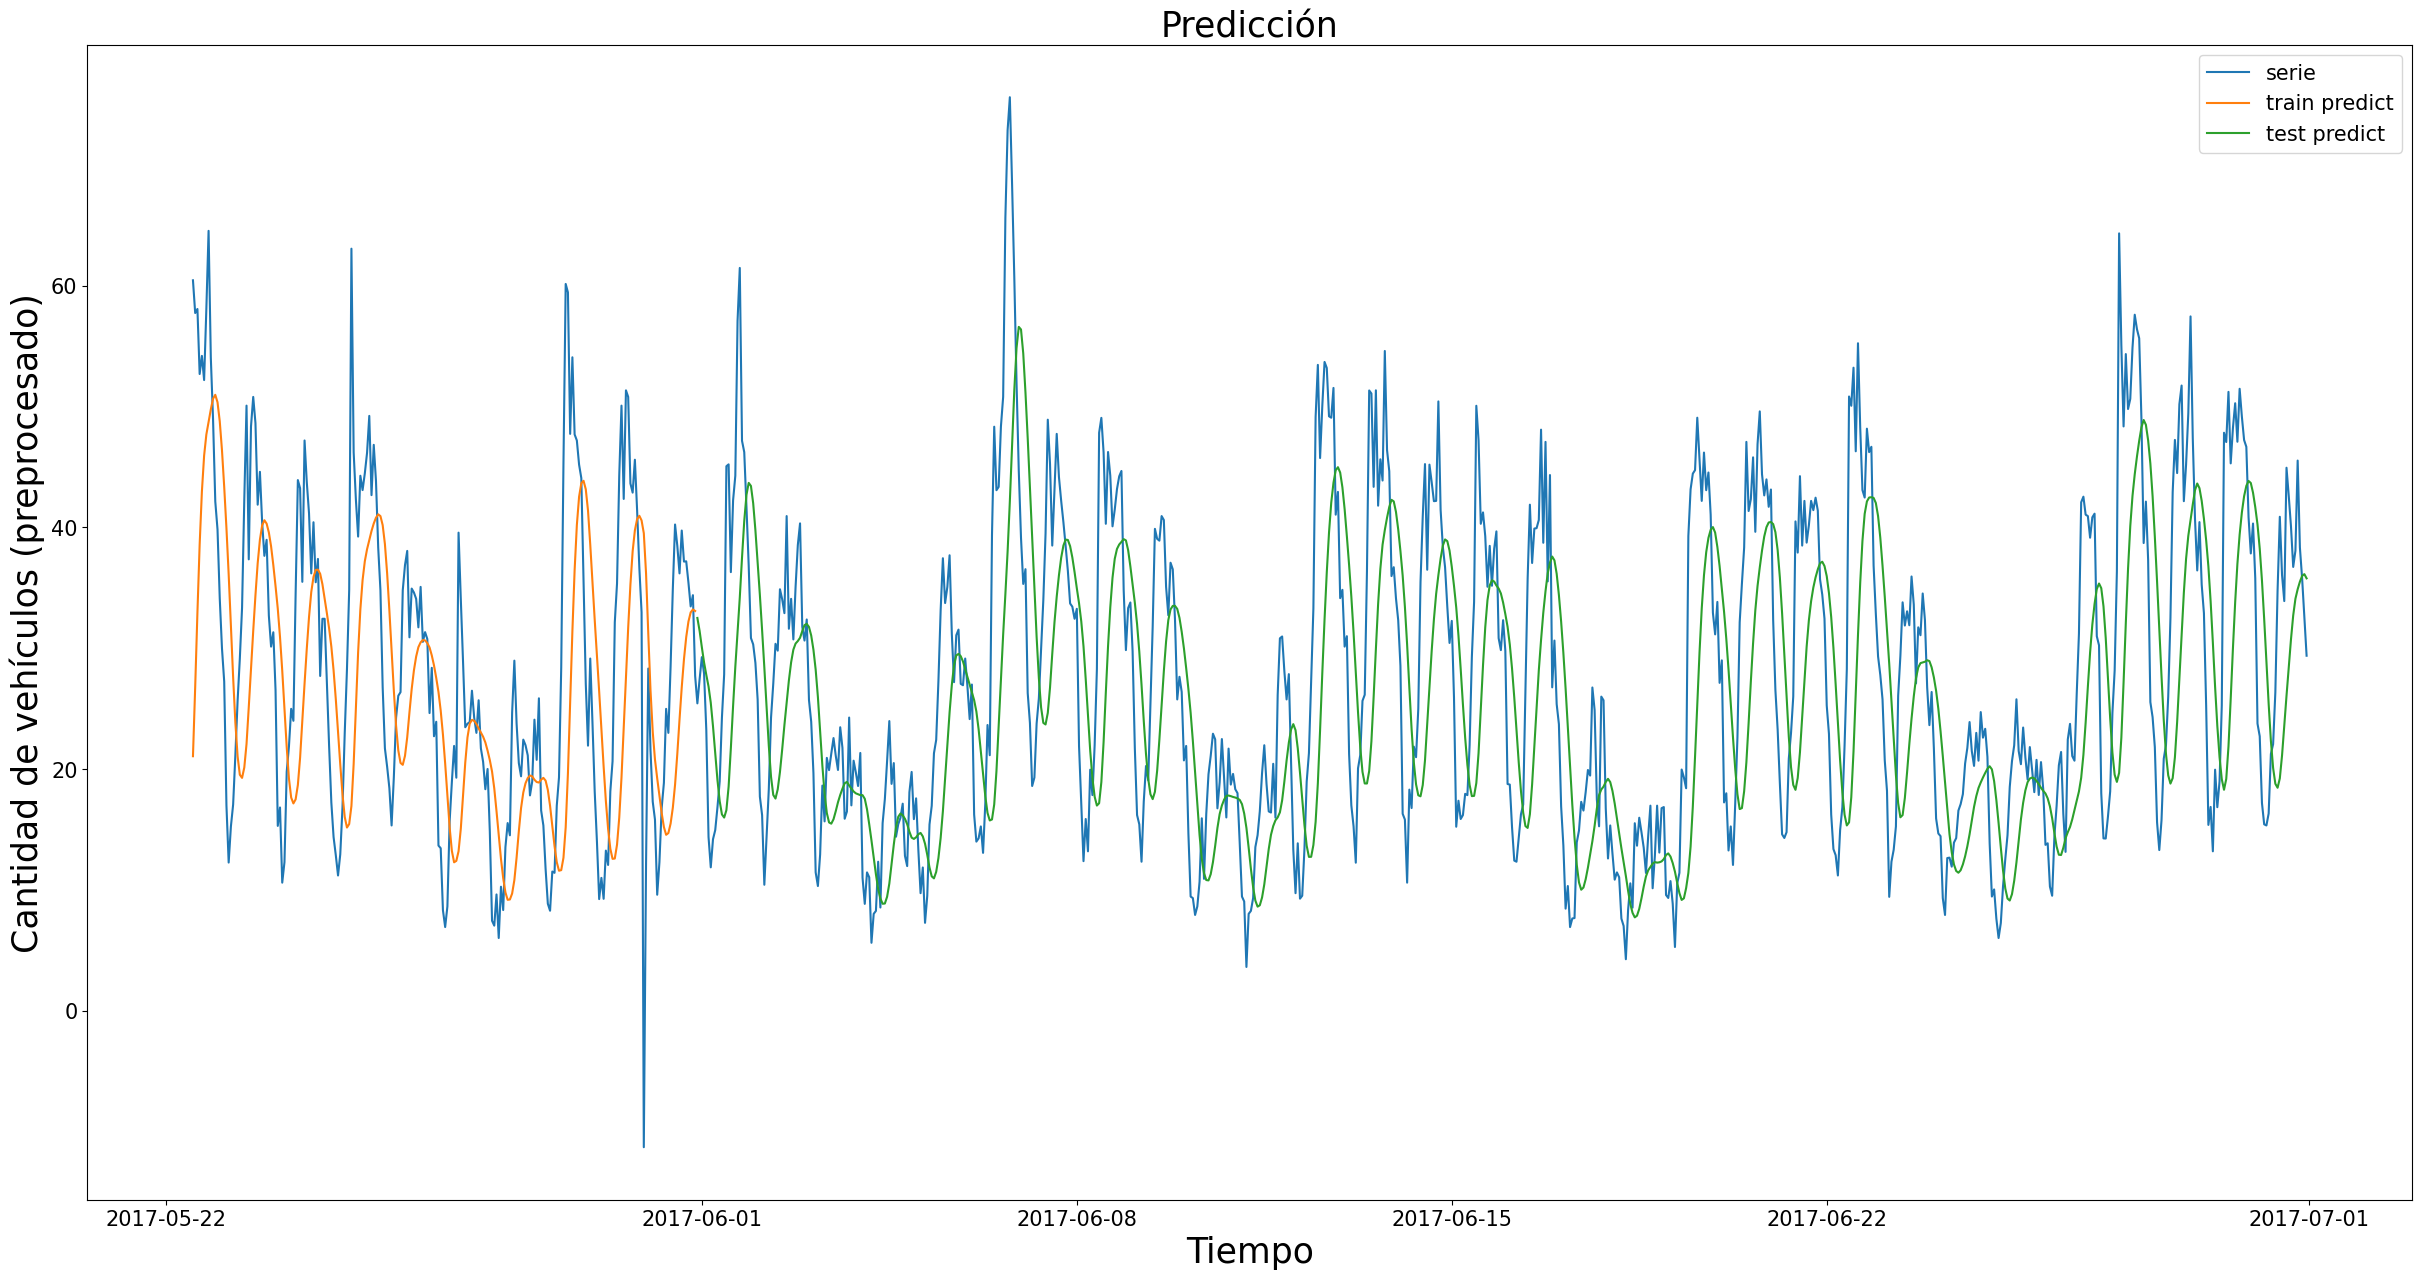

In [34]:
# plot baseline and predictions
zoom=13500
plt.plot(dataset_Junction1.index[start+zoom:],scaler.inverse_transform(resid.reshape(-1,1))[zoom:],label='serie')
plt.plot(dataset_Junction1.index[start+zoom:],y_hat_train_Plot[zoom:],label='train predict')
plt.plot(dataset_Junction1.index[start+zoom:],y_hat_Plot[zoom:],label='test predict')
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

##### Inferencia

In [35]:
#Predecir con los últimos cant_element datos de la serie preprocesada (en realidad en el caso anterior no se incluye el último dato).
cant_predictions_NN=len(resid)-cant_element
#print (resid[cant_predictions_NN:].shape)
predict_one=resid[cant_predictions_NN:].reshape(1, cant_element, 1)
#print (predict_one.shape)
y_hat_one= model.predict(predict_one)
y_hat_one = scaler.inverse_transform(y_hat_one)
print ("El valor predecido es:",y_hat_one)
print (y_hat_one.shape)

El valor predecido es: [[34.88005]]
(1, 1)


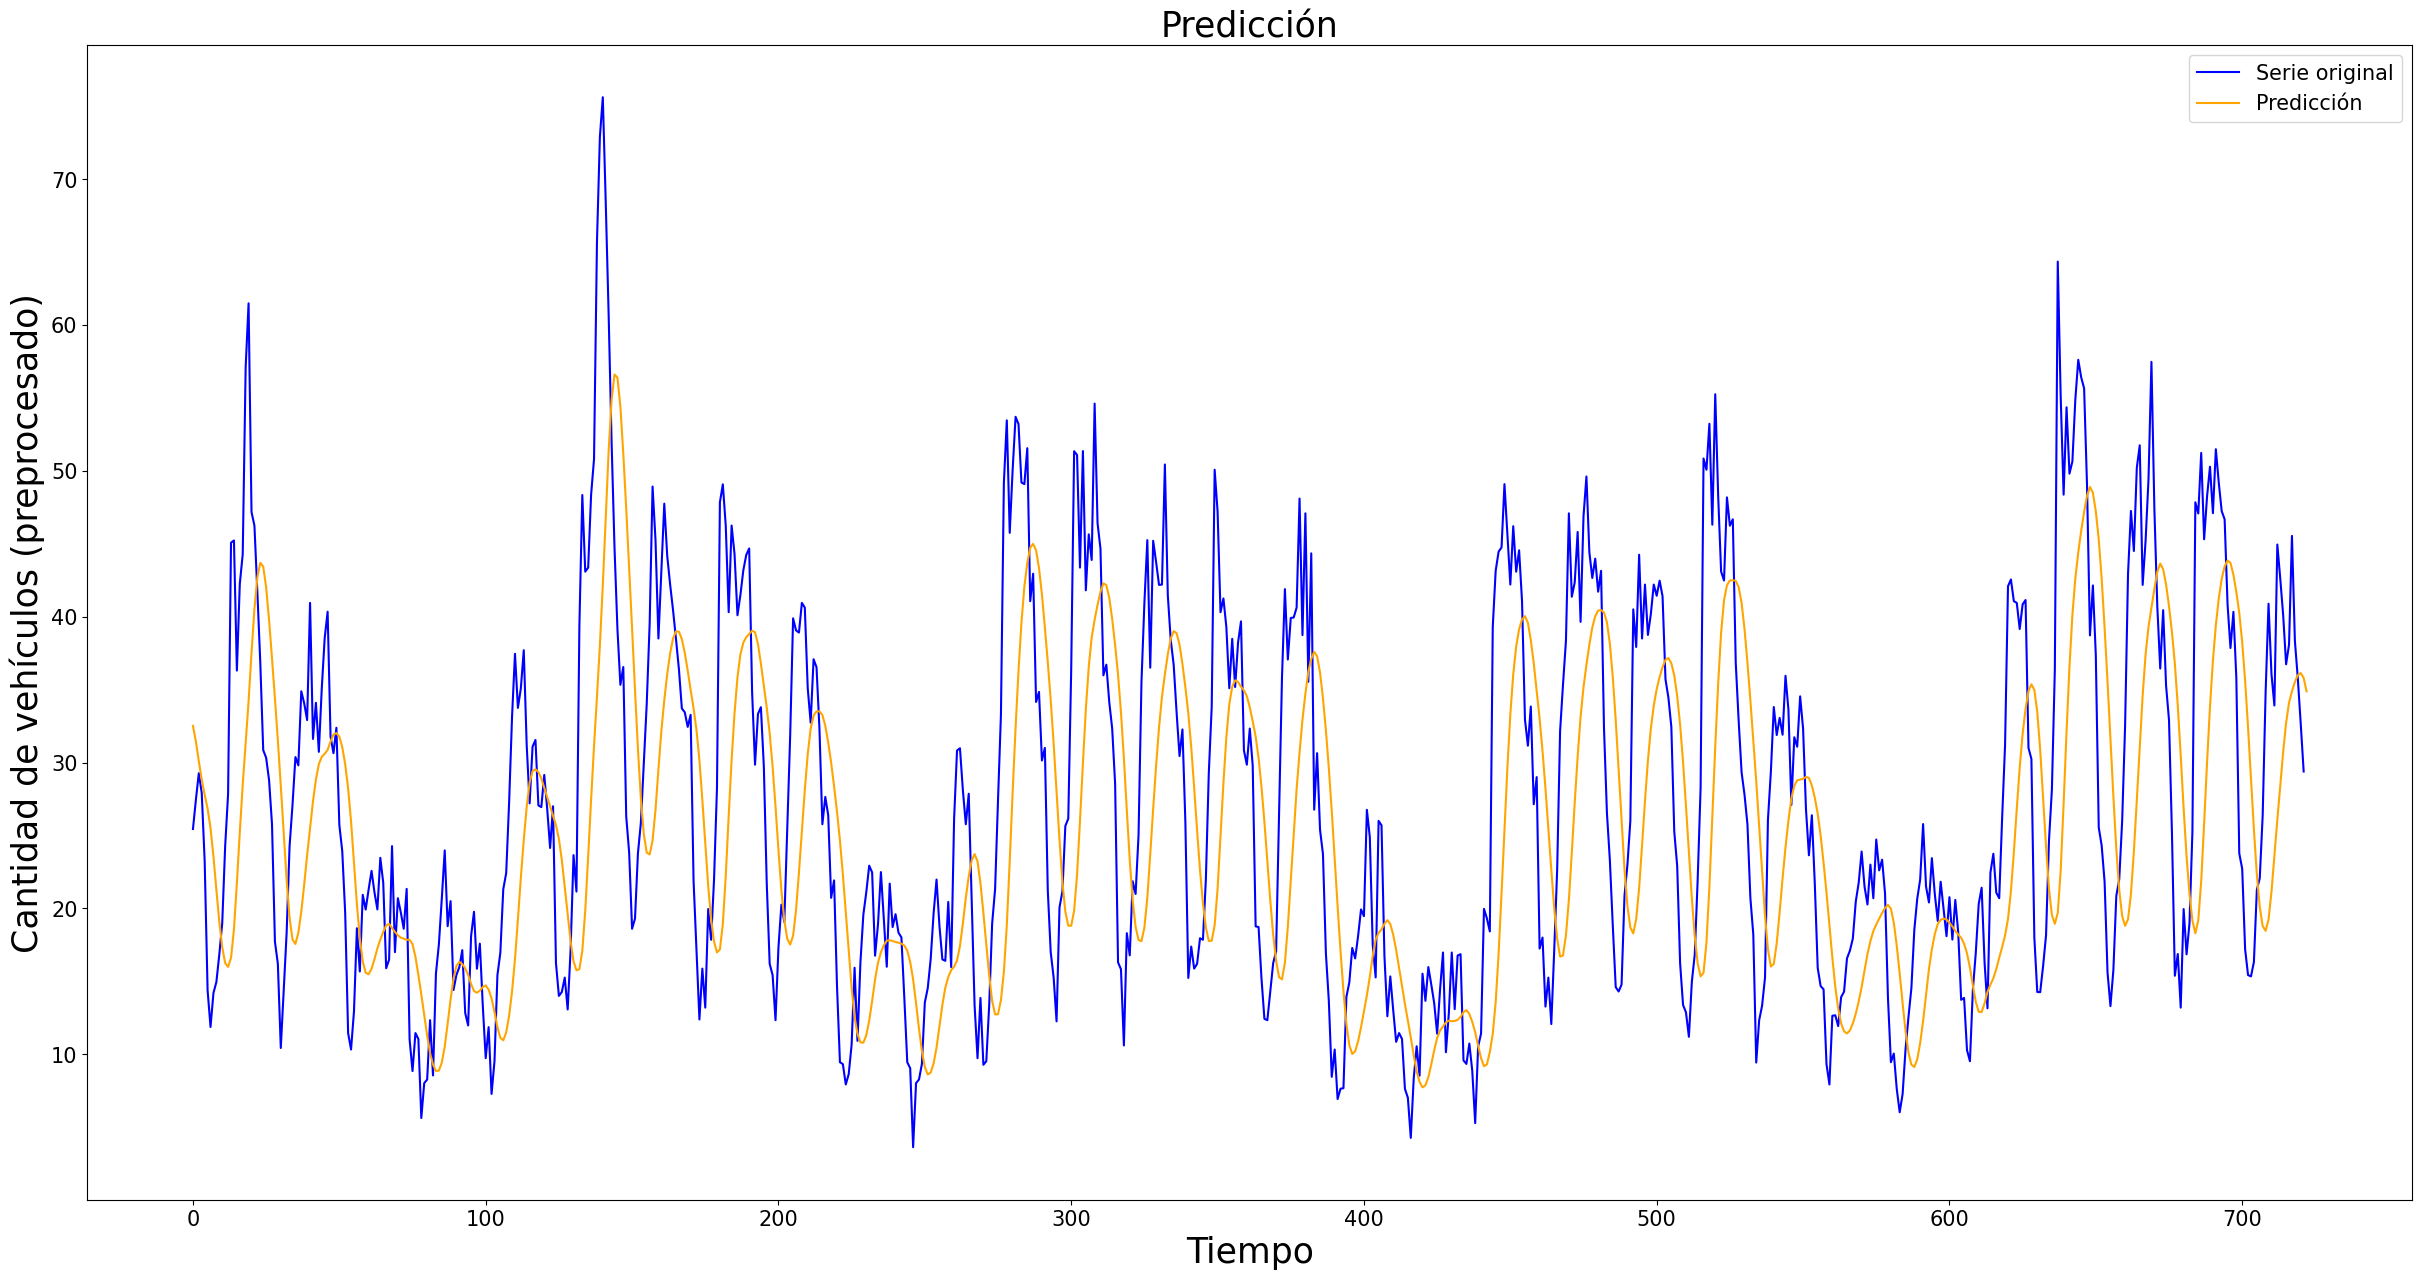

In [36]:
#print (y_hat.shape)
#print (y_hat_one.shape)
y_hat_complete=np.concatenate((y_hat,y_hat_one))
#print (y_hat_complete.shape)
plt.plot(y_test_inv, color="blue",label="Serie original")
plt.plot(y_hat_complete, color="orange",label="Predicción")
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

#### LSTM

In [37]:
model_2 = Sequential()
model_2.add(LSTM(units=50, input_shape=(input_shape), activation='relu'))
model_2.add(Dense(units=1))

model_2.compile(optimizer=Adam(),loss='mean_squared_error')

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


##### Entrenamiento y validación

In [38]:
hist_2 = model_2.fit(X_train,y_train, epochs=100, validation_split=0.2, batch_size=128)

Epoch 1/100
86/86 [==============================] - 5s 44ms/step - loss: 0.0149 - val_loss: 0.0036
Epoch 2/100
86/86 [==============================] - 3s 34ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 3/100
86/86 [==============================] - 3s 36ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/100
86/86 [==============================] - 3s 36ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 5/100
86/86 [==============================] - 3s 33ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 6/100
86/86 [==============================] - 3s 33ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 7/100
86/86 [==============================] - 3s 33ms/step - loss: 9.9607e-04 - val_loss: 0.0020
Epoch 8/100
86/86 [==============================] - 3s 33ms/step - loss: 9.0683e-04 - val_loss: 0.0021
Epoch 9/100
86/86 [==============================] - 3s 34ms/step - loss: 8.7471e-04 - val_loss: 0.0017
Epoch 10/100
86/86 [==============================] - 3s 33ms/step - loss: 8.4427e-04 - 

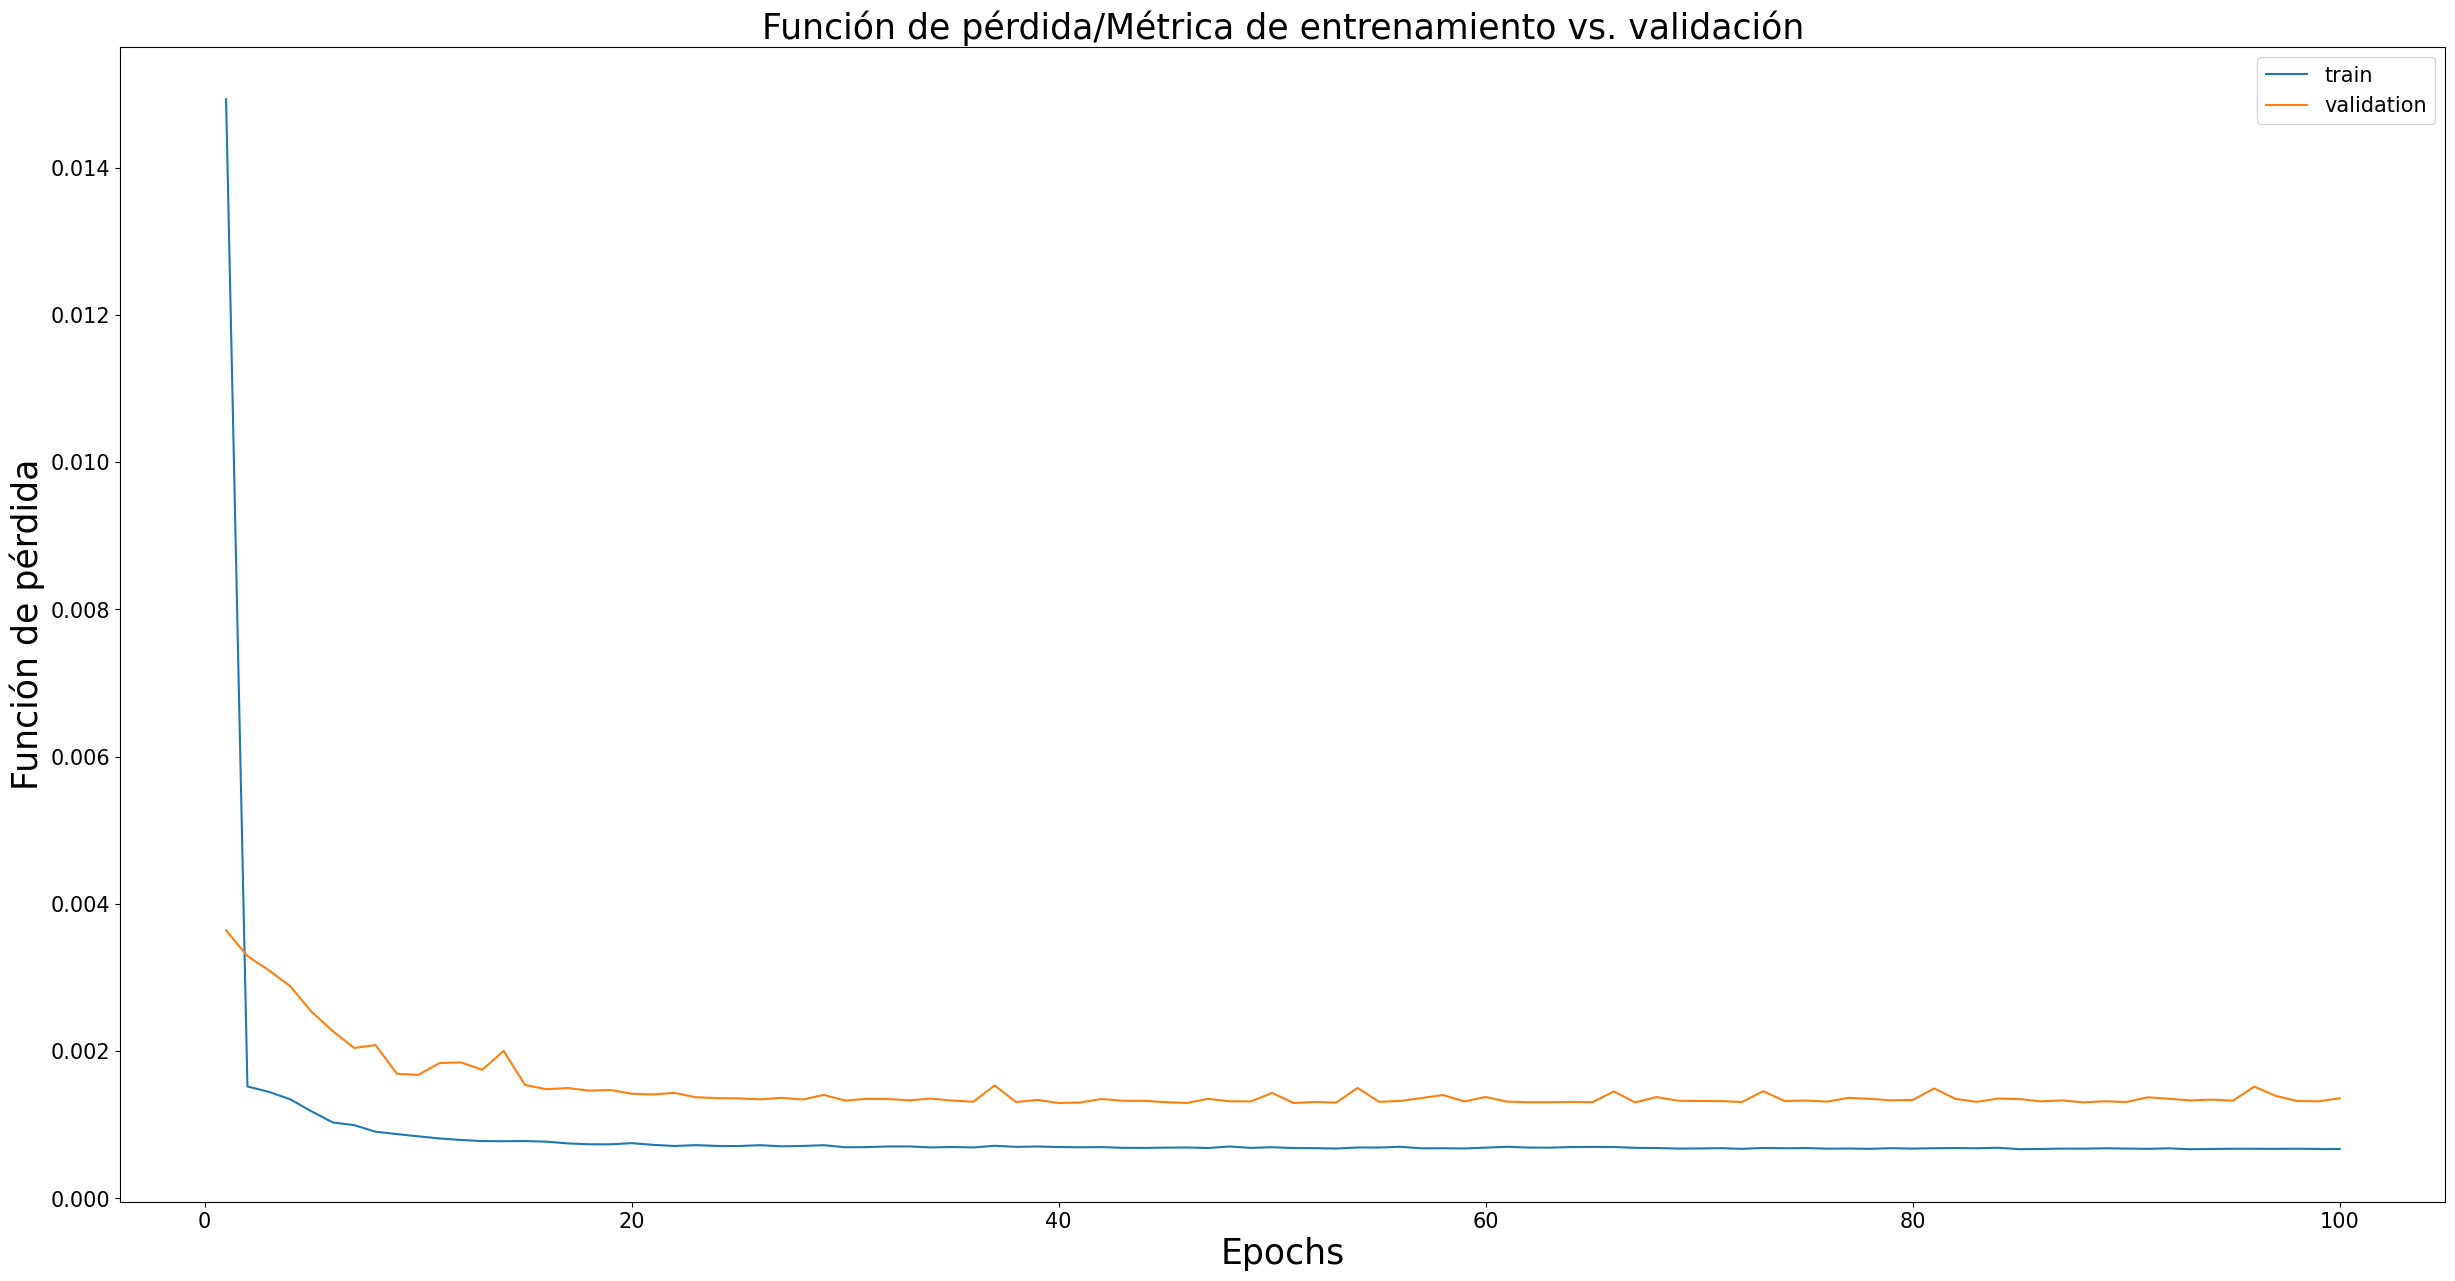

In [39]:
epoch_count_2 = range(1, len(hist_2.history['loss']) + 1)
plt.plot(epoch_count_2,hist_2.history['loss'],label='train')
plt.plot(epoch_count_2,hist_2.history['val_loss'],label='validation')
plt.title("Estimación de tendencia: caso cíclico 168 hs.")
plt.legend()
plt.title ("Función de pérdida/Métrica de entrenamiento vs. validación")
plt.xlabel("Epochs")
plt.ylabel("Función de pérdida")
plt.show()

##### Test

In [52]:
mse_evaluate_2=model_2.evaluate(X_test, y_test)
print (mse_evaluate_2)

23/23 [==============================] - 0s 5ms/step - loss: 0.0017
0.0016756171826273203


In [53]:
# Predecir solo con los datos.
# Predecir train.
y_hat_train_2=model_2.predict(X_train)
print (y_hat_train_2.shape)
# Predecir test.
y_hat_2= model_2.predict(X_test)
print (y_hat_2.shape)

(13702, 1)
(722, 1)


In [54]:
testScore_2 = np.sqrt(mean_squared_error(y_test, y_hat_2.flatten()))
print('Métrica de prueba: %.2f RMSE' % (testScore_2))

Métrica de prueba: 0.04 RMSE


In [55]:
# Invertir las predicciones de test.
print (y_hat_2.shape)
y_hat_2 = scaler.inverse_transform(y_hat_2)
print (y_hat_2.shape)
print (y_test.shape)
# El reshape es porque el scaler requiere esa forma.
y_test_inv_2 = y_test.reshape(-1,1)
y_test_inv_2 = scaler.inverse_transform(y_test_inv_2)
# El flatten es para volver los datos a la forma original.
y_test_inv_2 = y_test_inv_2.flatten()
print (y_test_inv_2.shape)

(722, 1)
(722, 1)
(722,)
(722,)


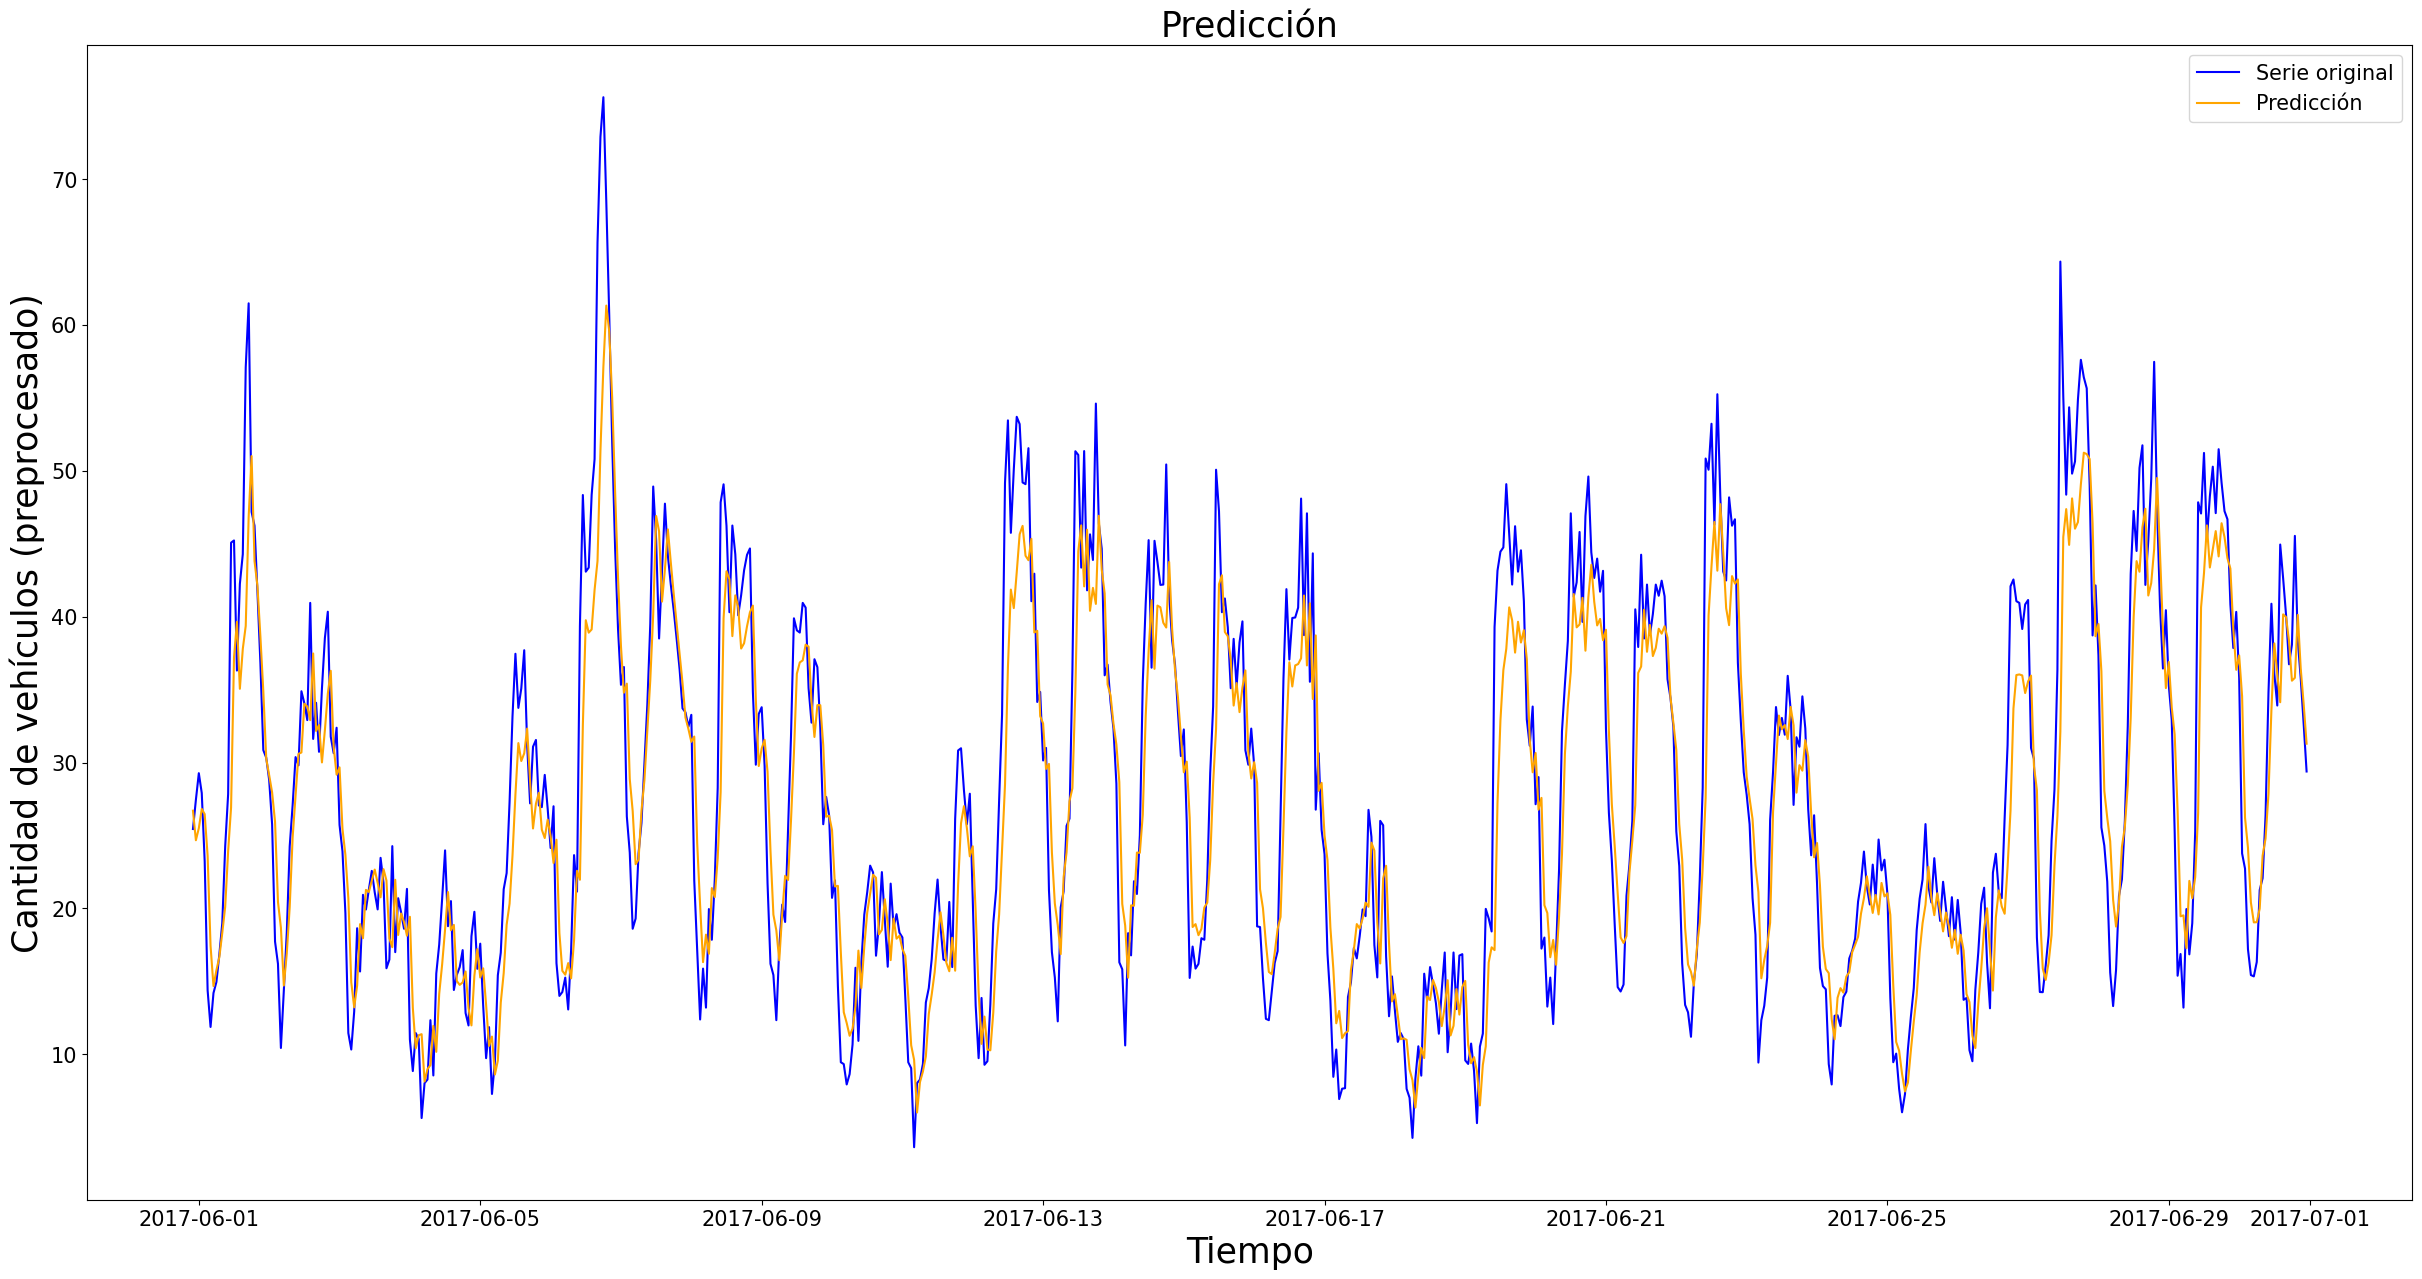

In [56]:
# Graficar datos de prueba y predicción.
init_2=len(resid)-len(y_test_inv_2)+start
plt.plot(dataset_Junction1.index[init_2:],y_test_inv_2, color="blue",label="Serie original")
plt.plot(dataset_Junction1.index[init_2:],y_hat_2, color="orange",label="Predicción")
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

In [57]:
# Invertir las predicciones de train.
print(y_hat_train_2.shape)
y_hat_train_2 = scaler.inverse_transform(y_hat_train_2)
print (y_hat_train_2.shape)
# print (y_train.shape)
# # El reshape es porque el scaler requiere esa forma.
# y_train_inv = y_train.reshape(-1,1)
# y_train_inv = scaler.inverse_transform(y_train_inv)
# # El flatten es para volver los datos a la forma original.
# y_train_inv = y_train_inv.flatten()
# print (y_train_inv.shape)

(13702, 1)
(13702, 1)


In [58]:
# Mover las predicciones de train para graficar.
y_hat_train_Plot_2 = np.empty_like(resid.reshape(-1,1))
y_hat_train_Plot_2[:,:] = np.nan
y_hat_train_Plot_2[cant_element:len(y_hat_train_2)+cant_element, :] = y_hat_train_2
print (y_hat_train_Plot_2.shape)

(14448, 1)


In [59]:
# Mover las predicciones de test para graficar.
y_hat_Plot_2 = np.empty_like(resid.reshape(-1,1))
y_hat_Plot_2[:, :] = np.nan
y_hat_Plot_2[len(y_hat_train_2)+(cant_element):len(resid.reshape(-1,1)), :] = y_hat_2
print (y_hat_Plot_2.shape)

(14448, 1)


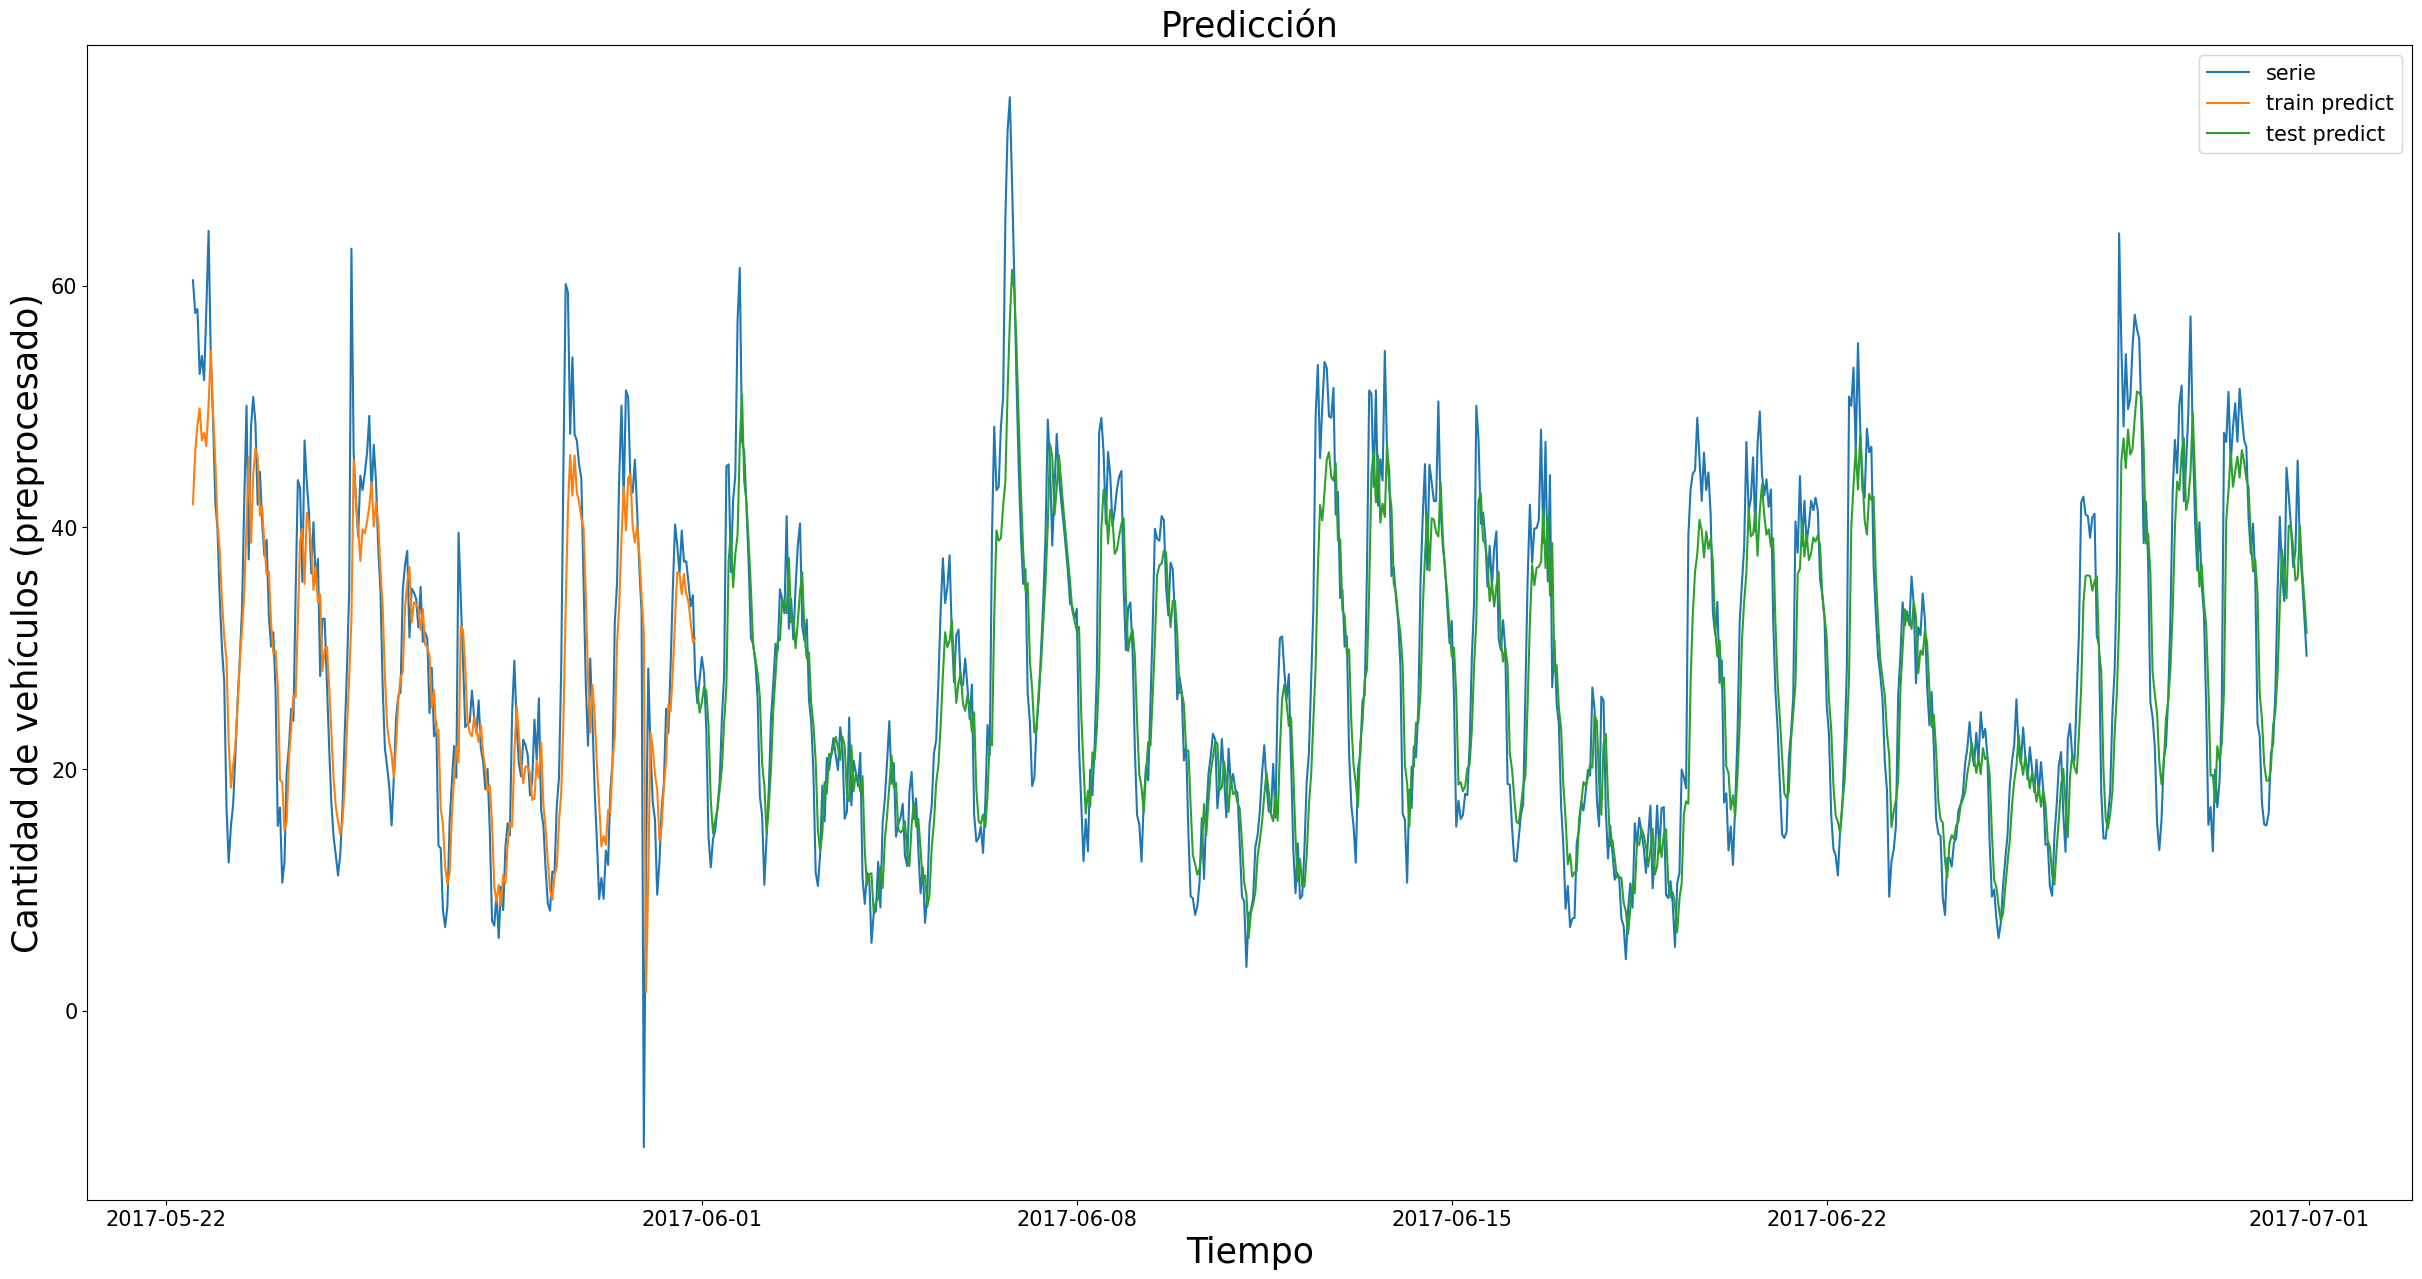

In [60]:
# plot baseline and predictions
zoom=13500
plt.plot(dataset_Junction1.index[start+zoom:],scaler.inverse_transform(resid.reshape(-1,1))[zoom:],label='serie')
plt.plot(dataset_Junction1.index[start+zoom:],y_hat_train_Plot_2[zoom:],label='train predict')
plt.plot(dataset_Junction1.index[start+zoom:],y_hat_Plot_2[zoom:],label='test predict')
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

##### Inferencia

In [61]:
#Predecir con los últimos cant_element datos de la serie preprocesada (en realidad en el caso anterior no se incluye el último dato).
cant_predictions_NN_2=len(resid)-cant_element
#print (resid[cant_predictions_NN:].shape)
predict_one_2=resid[cant_predictions_NN_2:].reshape(1, cant_element, 1)
#print (predict_one.shape)
y_hat_one_2= model.predict(predict_one_2)
y_hat_one_2 = scaler.inverse_transform(y_hat_one_2)
print ("El valor predecido es:",y_hat_one_2)
print (y_hat_one_2.shape)

El valor predecido es: [[34.88005]]
(1, 1)


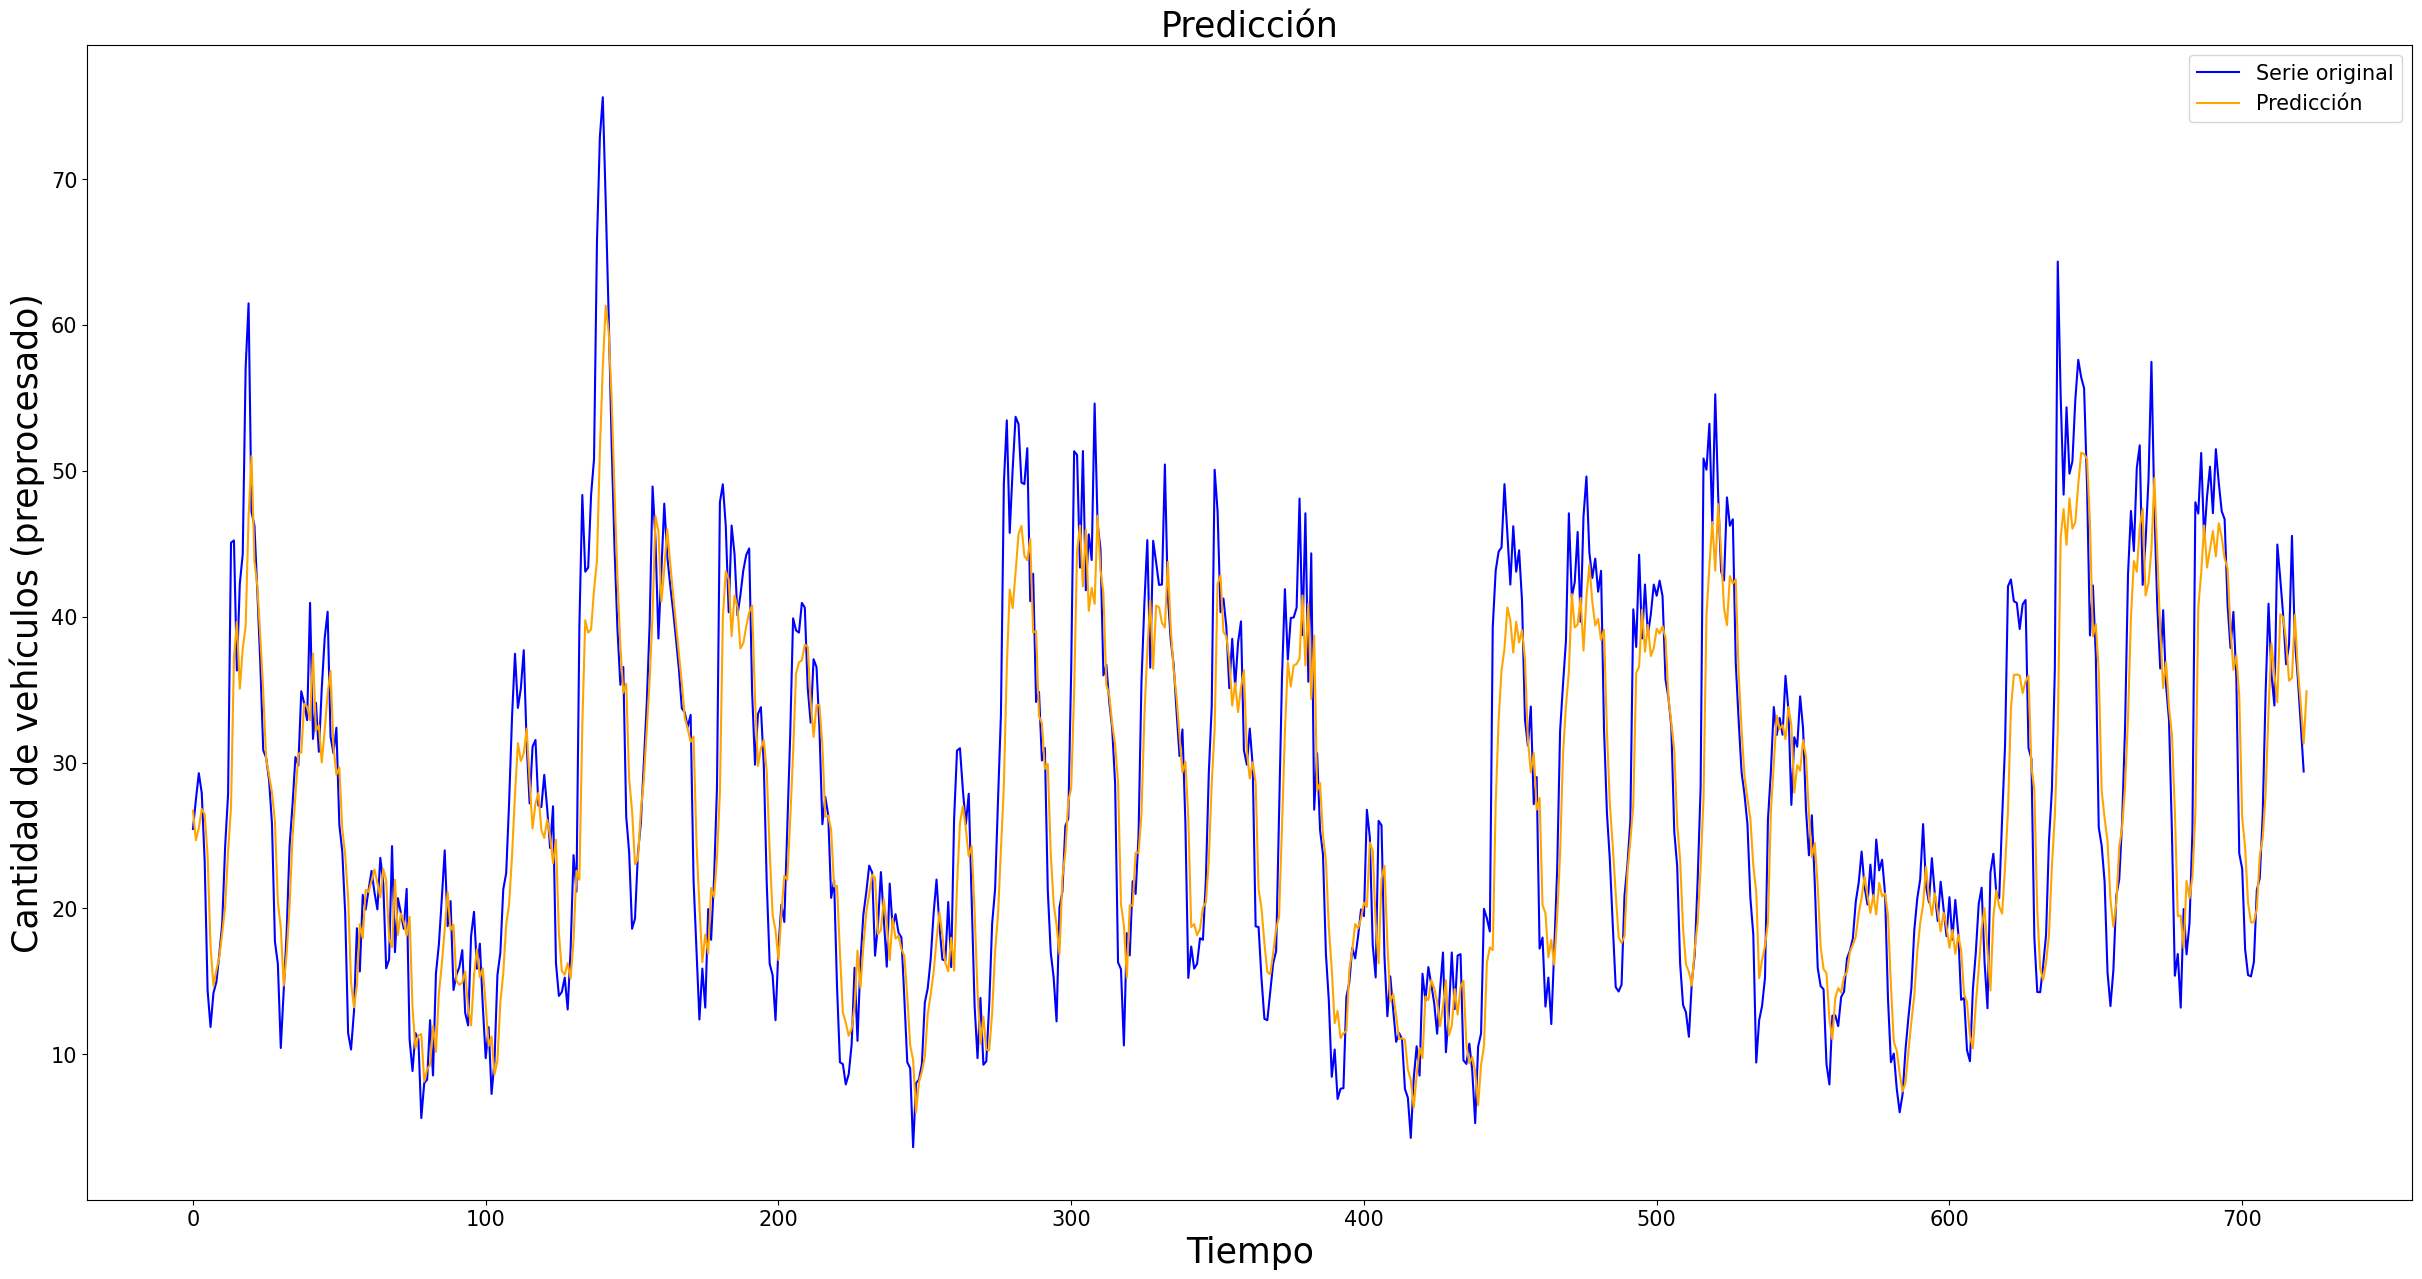

In [62]:
#print (y_hat.shape)
#print (y_hat_one.shape)
y_hat_complete_2=np.concatenate((y_hat_2,y_hat_one_2))
#print (y_hat_complete.shape)
plt.plot(y_test_inv_2, color="blue",label="Serie original")
plt.plot(y_hat_complete_2, color="orange",label="Predicción")
plt.legend()
plt.title("Predicción")
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos (preprocesado)")
plt.show()

## Conclusiones

### Redes neuronales GRU Vs. LSTM

In [63]:
metrics_show = [ ["GRU", testScore, mse_evaluate],
                 ["LSTM", testScore_2, mse_evaluate_2]]
dataframe_conclusion = pd.DataFrame(metrics_show, columns = ['Nombre','RMSE (predict)','MSE (evaluate)'])
print(dataframe_conclusion)

  Nombre  RSME (predict)  MSE (evaluate)
0    GRU        0.087146        0.007594
1   LSTM        0.040934        0.001676


En las métricas se ve claramente que la red neuronal LSTM predice mejor. Esto hace sentido, ya que la GRU evolucionó a una LSTM.
Además, si observamos los gráficos, LSTM se ajusta mejor y no tiene desfazaje en la predicción.

### Redes neuronales vs. SARIMA

En la notebook de SARIMA se obtienen los siguientes gráficos:

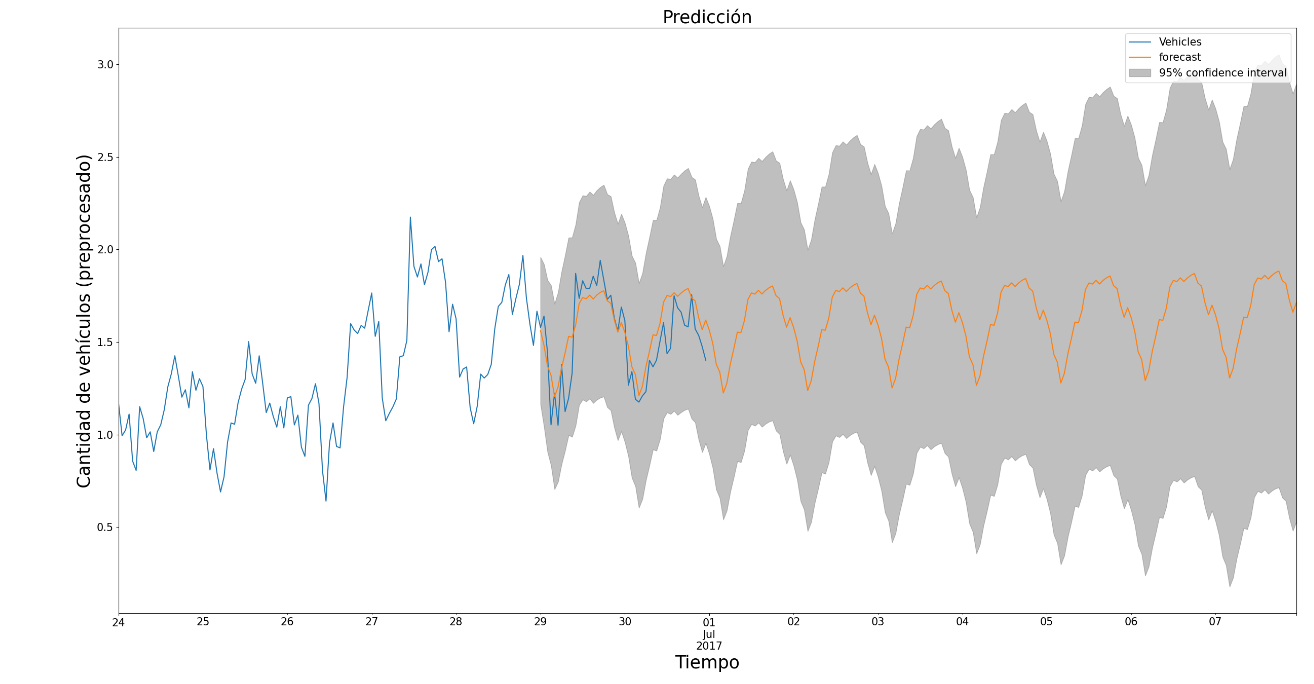

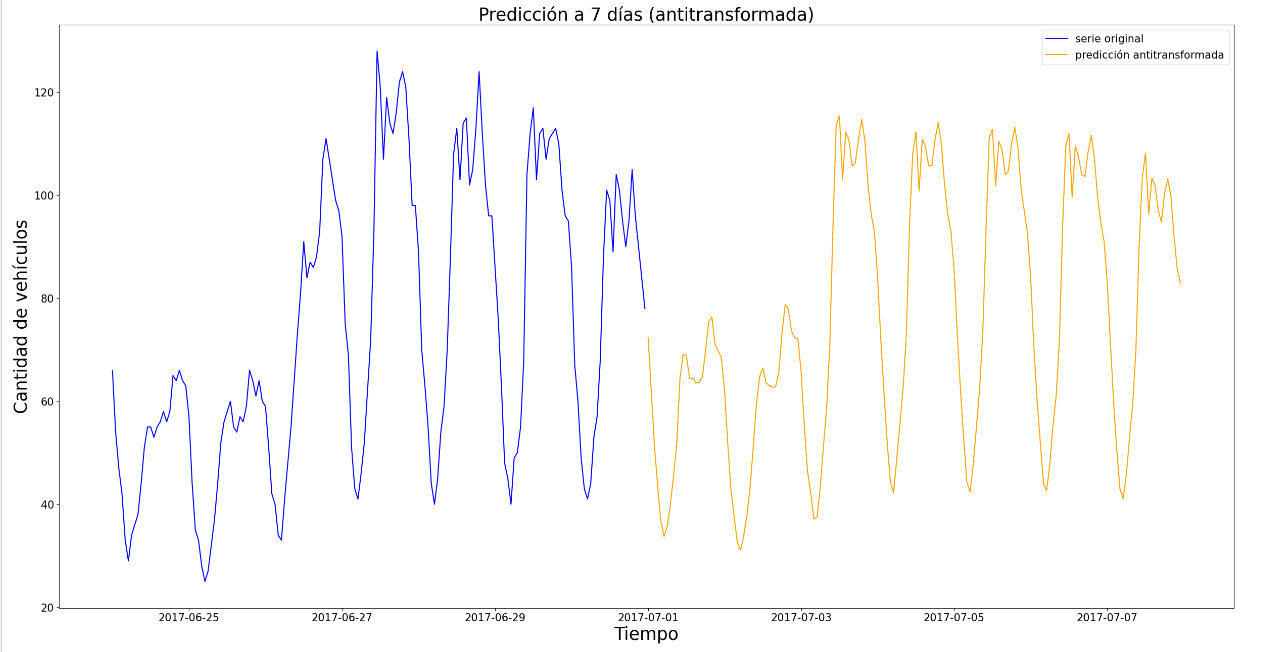

Se puede observar que, descontando la tendencia determinística semanal, SARIMA se centra solamente en la tendencia a 24 horas, en cambio las redes neuronales, permiten captar también la tendencia semanal, realizando un mejor ajuste. 
SARIMA y LSTM ajustan sin desfasaje en comparación con GRU. 
Si a SARIMA se la anti-transforma, agregando la tendencia determinística a 1 semana, se asemeja más a lo obtenido en la red LSTM. 